In [1]:
import requests
import os
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

True

## 対象PDF

In [2]:
filename = "../data/insurance/tokyo_marine_yakkan_sample.pdf"
# filename = "../data/tokyo_marine/tokyo_marine_total_assist_yakkan_250101.pdf"

Pages [16, 17, 18, 19, 20, 28] extracted to: ../data/insurance/tokyo_marine_yakkan_sample/temp_pages_16-17-18-19-20-28.pdf


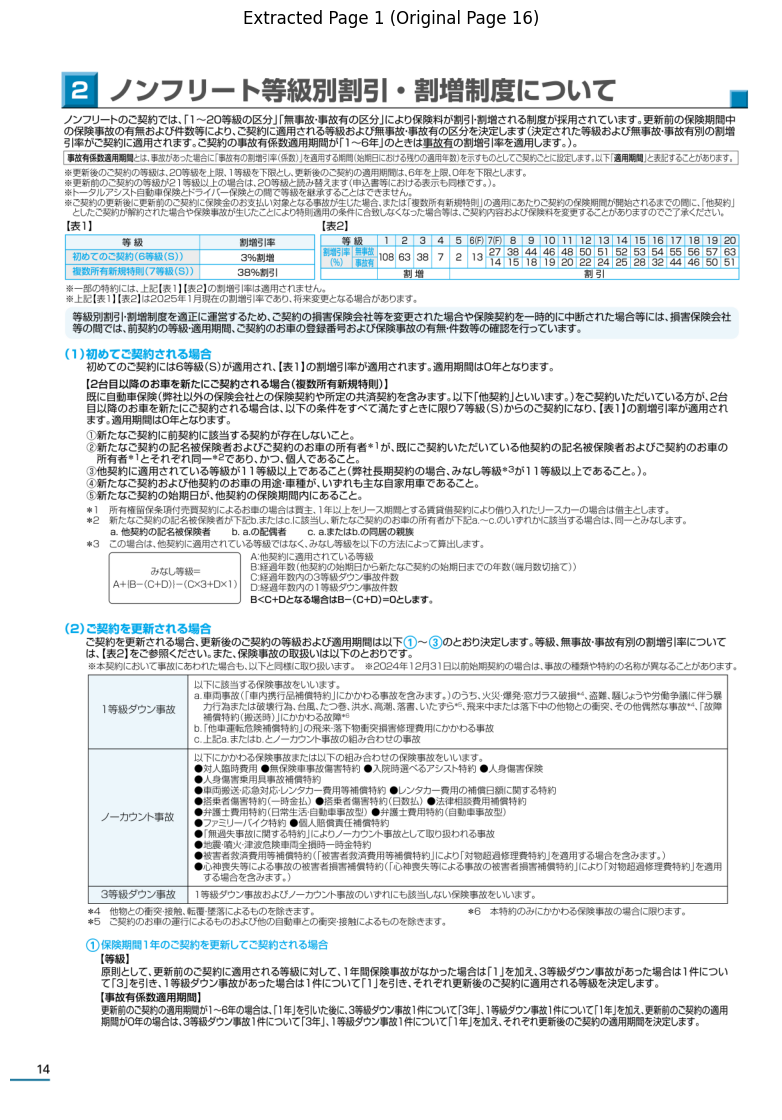

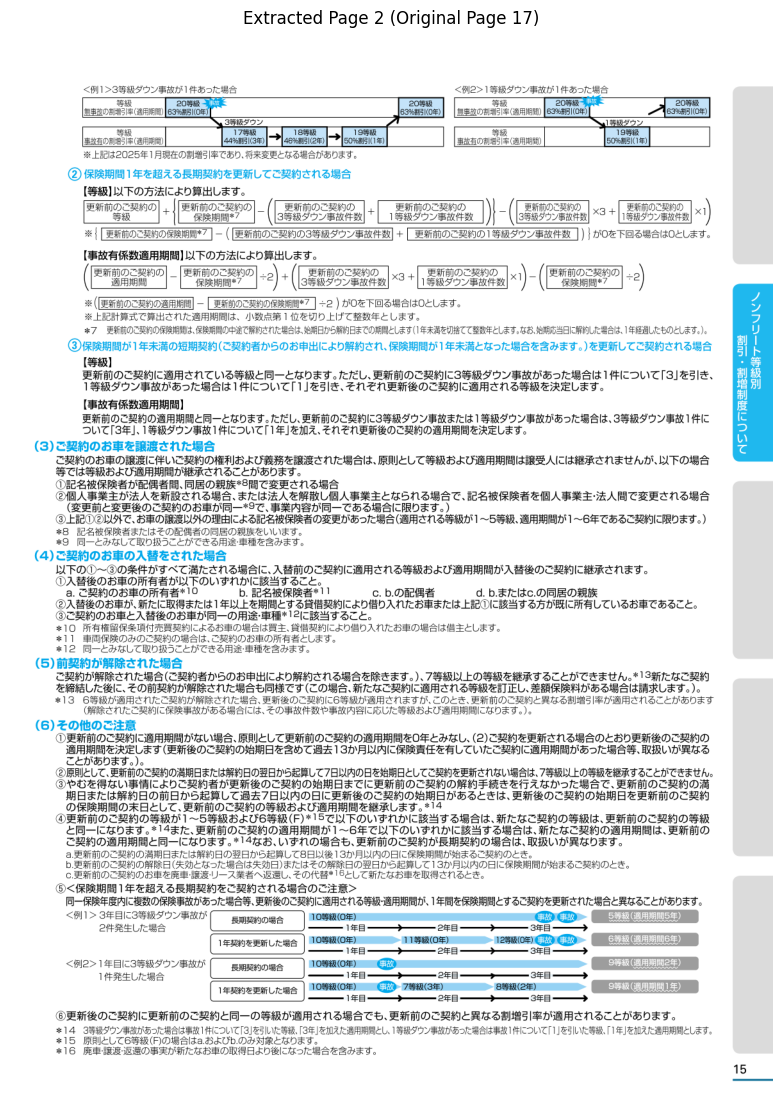

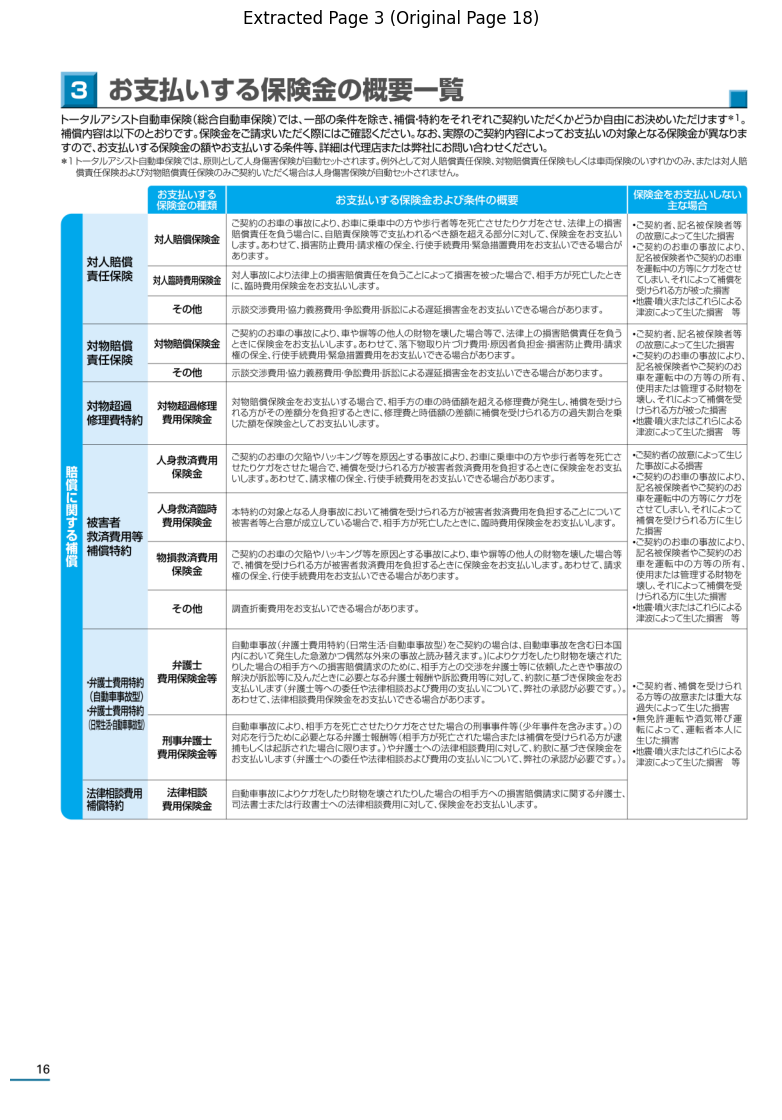

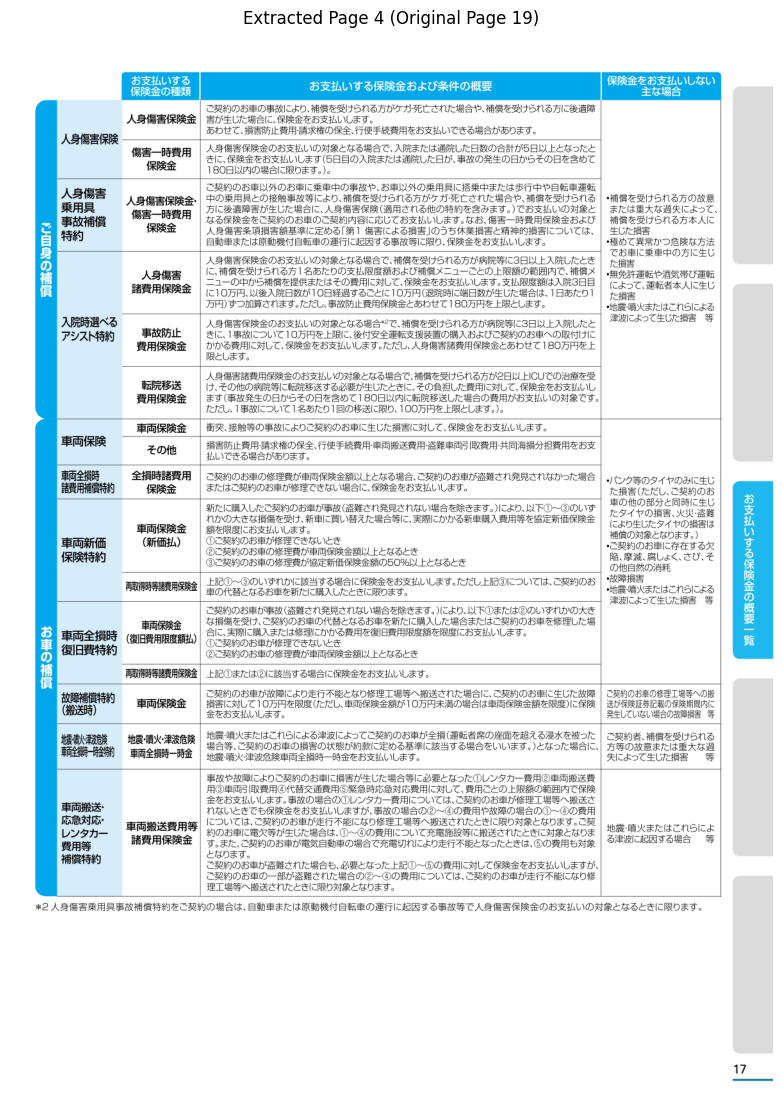

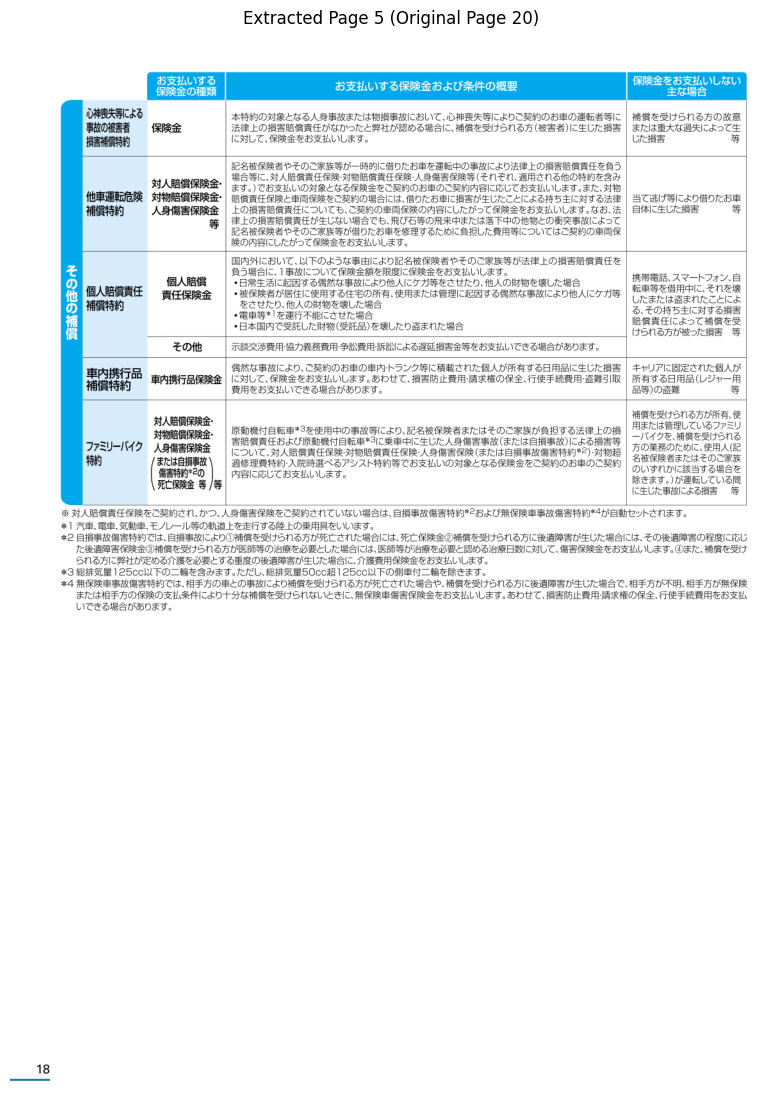

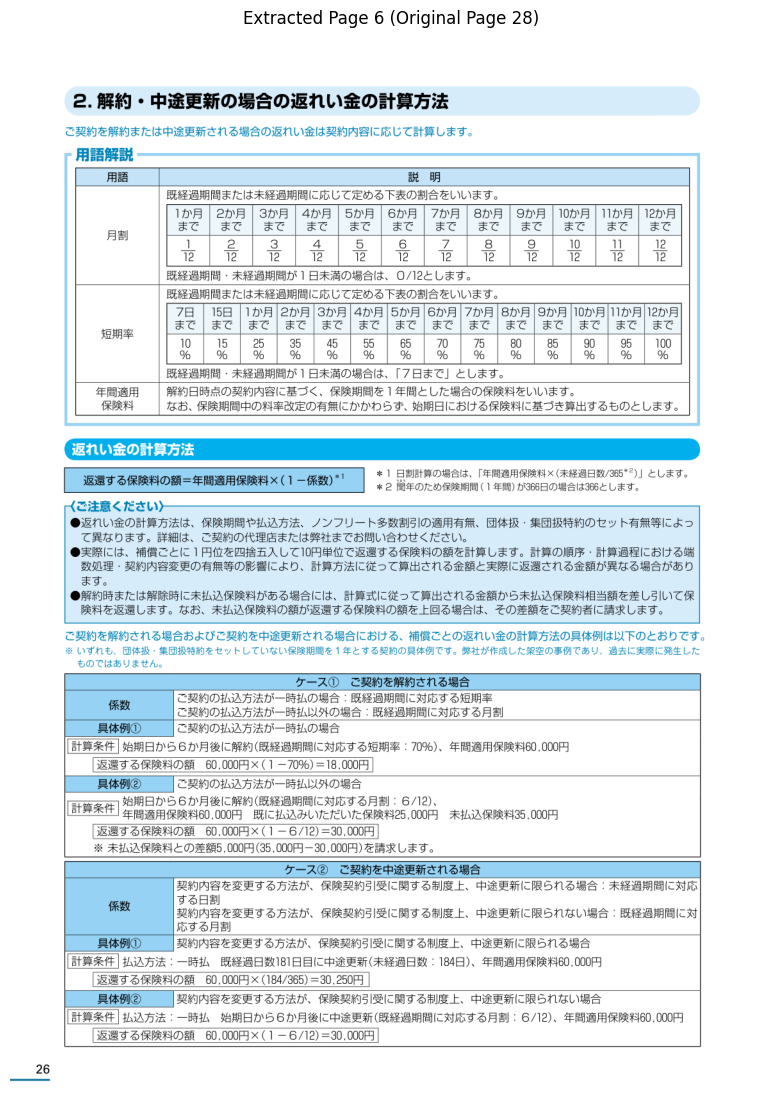

In [3]:
# PDFファイルから指定ページを抽出して一時ファイルを作成
import fitz  # PyMuPDF
import matplotlib.pyplot as plt

file_path = Path(filename)
pdf_document = fitz.open(file_path)

# ドキュメントの総ページ数を事前に取得
total_pages = pdf_document.page_count

# 抽出したいページ番号をリスト形式で指定（0ベースのインデックス）
page_numbers = list(range(16, 21)) + [28]

# 存在するページのみをフィルタリング
valid_pages = [p - 1 for p in page_numbers if p < total_pages]
invalid_pages = [p - 1 for p in page_numbers if p >= total_pages]

# 警告表示
for page_num in invalid_pages:
    print(f"Warning: Page {page_num+1} does not exist in the document (total pages: {total_pages})")

# 抽出ページ情報（1ベース）
extracted_pages = [p+1 for p in valid_pages]

# 一時PDFファイルのパスを作成
page_list_str = "-".join(map(str, extracted_pages))  # 1ベースでファイル名作成
temp_pdf_path = Path(f"../data/{filename.split('/')[-2]}/{filename.split('/')[-1].split('.')[0]}/temp_pages_{page_list_str}.pdf")
temp_pdf_path.mkdir(parents=True, exist_ok=True)

# 新しいPDFドキュメントを作成
new_doc = fitz.open()

# 指定されたページを新しいドキュメントに追加
for page_num in valid_pages:
    new_doc.insert_pdf(pdf_document, from_page=page_num, to_page=page_num)

# 一時PDFファイルとして保存
new_doc.save(temp_pdf_path)
new_doc.close()
pdf_document.close()

print(f"Pages {extracted_pages} extracted to: {temp_pdf_path}")

# 後続処理用のファイルパス変数を設定
extracted_pdf_path = temp_pdf_path

# オプション: 抽出したページを表示（確認用）
display_pages = True
# display_pages = False  # 表示が不要な場合はFalseに設定

if display_pages:
    pdf_document = fitz.open(temp_pdf_path)
    for page_num in range(pdf_document.page_count):
        page = pdf_document[page_num]
        pix = page.get_pixmap(matrix=fitz.Matrix(2, 2))
        img_data = pix.pil_tobytes(format="PNG")

        from PIL import Image   
        import io
        img = Image.open(io.BytesIO(img_data))

        plt.figure(figsize=(10, 14))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Extracted Page {page_num + 1} (Original Page {valid_pages[page_num] + 1})')
        plt.show()
    pdf_document.close()

In [5]:
# PDFファイルを1ページごとに分割して保存
import os

# 分割ページ保存用のディレクトリを作成
split_pages_dir = Path(f"../data/{filename.split('/')[-2]}/{filename.split('/')[-1].split('.')[0]}/split_pages")
split_pages_dir.mkdir(parents=True, exist_ok=True)

# 抽出されたPDFファイルを開く
pdf_document = fitz.open(extracted_pdf_path)

# 各ページを個別のPDFファイルとして保存
for page_num in range(pdf_document.page_count):
    # 新しいPDFドキュメントを作成
    single_page_doc = fitz.open()
    
    # 現在のページを新しいドキュメントに挿入
    single_page_doc.insert_pdf(pdf_document, from_page=page_num, to_page=page_num)
    
    # ファイル名を作成（元のページ番号を使用）
    original_page_num = valid_pages[page_num] + 1  # 1ベースに変換
    single_page_filename = f"page_{original_page_num:03d}.pdf"
    single_page_path = split_pages_dir / single_page_filename
    
    # 単一ページPDFとして保存
    single_page_doc.save(single_page_path)
    single_page_doc.close()
    
    print(f"Page {original_page_num} saved to: {single_page_path}")

pdf_document.close()

print(f"\n全{len(valid_pages)}ページが個別のPDFファイルとして保存されました。")
print(f"保存先ディレクトリ: {split_pages_dir}")


Page 12 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_012.pdf
Page 13 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_013.pdf
Page 14 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_014.pdf
Page 15 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_015.pdf
Page 16 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_016.pdf
Page 17 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_017.pdf
Page 18 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_018.pdf
Page 19 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_019.pdf
Page 20 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_020.pdf
Page 21 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_021.pdf
Page 22 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_022.pdf
Page 23 saved to: ../data/nissei/nissei_miraino_katachi/split_pages/page_023.pdf
Page 24 saved to: ../data/ni

## Upstage/Document Parse

In [7]:
from IPython.display import display, HTML

api_key = os.getenv("UPSTAGE_API_KEY")
 
url = "https://api.upstage.ai/v1/document-digitization"
headers = {"Authorization": f"Bearer {api_key}"}
# extracted_pdf_pathを使用（前のセルで設定された一時PDFファイル）
files = {"document": open(extracted_pdf_path, "rb")}
data = {"ocr": "force", "base64_encoding": "['table']", "model": "document-parse-nightly"}
response = requests.post(url, headers=headers, files=files, data=data)
if response.status_code != 200:
    raise Exception(f"Error: {response.status_code} - {response.text}")
content = response.json()["content"]["html"]
display(HTML(content))

In [13]:
# htmlの文字化けを解消したい。

from bs4 import BeautifulSoup
import chardet

def normalize_html_content(content):
    # bytesならエンコーディング推定→デコード
    if isinstance(content, (bytes, bytearray)):
        enc = chardet.detect(content).get("encoding") or "utf-8"
        text = content.decode(enc, errors="replace")
    else:
        text = content

    # <meta charset="utf-8"> を保証
    soup = BeautifulSoup(text, "html.parser")
    if soup.head is None:
        # head がない場合は作る
        html = soup.new_tag("html")
        head = soup.new_tag("head")
        body = soup.new_tag("body")
        body.append(soup)  # 既存ノードを body 下へ
        html.append(head)
        html.append(body)
        soup = BeautifulSoup(str(html), "html.parser")

    if not soup.head.find("meta", attrs={"charset": True}):
        meta = soup.new_tag("meta", charset="utf-8")
        soup.head.insert(0, meta)
    else:
        soup.head.find("meta", attrs={"charset": True})["charset"] = "utf-8"

    return str(soup)

# 保存時
html_file_path = extracted_pdf_path.with_suffix(".html")
html_text = normalize_html_content(content)
with open(html_file_path, "w", encoding="utf-8", newline="") as f:
    f.write(html_text)

## Azure Document Intelligence

In [14]:
from azure.core.credentials import AzureKeyCredential
from azure.ai.documentintelligence import DocumentIntelligenceClient
from azure.ai.documentintelligence.models import AnalyzeResult, AnalyzeDocumentRequest, DocumentContentFormat

client = DocumentIntelligenceClient(
            endpoint=os.getenv("AZURE_DOCUMENT_INTELLIGENCE_ENDPOINT"),
            credential=AzureKeyCredential(os.getenv("AZURE_DOCUMENT_INTELLIGENCE_API_KEY"))
        )

# extracted_pdf_pathを使用（前のセルで設定された一時PDFファイル）
with extracted_pdf_path.open("rb") as file:
    poller = client.begin_analyze_document(
        model_id="prebuilt-layout",
        body=file,
        output_content_format=DocumentContentFormat.MARKDOWN
    )
result: AnalyzeResult = poller.result()

In [16]:
from IPython.display import display, Markdown

display(Markdown(result.content))

<!-- PageHeader="ご契約にあたって" -->


# 1 ニッセイみらいのカタチの特徴

ニッセイみらいのカタチは、ライフプランにあわせて、
『保険種類』·『保険期間のタイプ』を自在に設計できる保険です。

『保険種類』の選択

『保険期間のタイプ』の選択


# 『保険種類』の選択

■複数の保険契約を組み合わせて一体の保険として加入することができます。

■単独で加入することもできます。

P13·14もあ
わせてお読みくだ
さい。


## く複数の保険契約を組み合わせて加入する場合に選択できる保険種類の>


<table>
<tr>
<td></td>
<td>終身保険 *</td>
<td>P44</td>
</tr>
<tr>
<td colspan="2" rowspan="2">年金 保 険</td>
<td></td>
</tr>
<tr>
<td>P46</td>
</tr>
<tr>
<td colspan="2" rowspan="2">生存給付金付定期保険 *</td>
<td></td>
</tr>
<tr>
<td>P49</td>
</tr>
<tr>
<td colspan="2" rowspan="2">特定重度疾病保障保険</td>
<td></td>
</tr>
<tr>
<td>P64</td>
</tr>
<tr>
<td colspan="2" rowspan="2">認知症保障保険</td>
<td></td>
</tr>
<tr>
<td>P80</td>
</tr>
<tr>
<td colspan="2"></td>
<td></td>
</tr>
<tr>
<td></td>
<td>がん医療保険</td>
<td>P95</td>
</tr>
</table>


<figure>
</figure>


<table>
<tr>
<th>養老保険 *</th>
<th>P45</th>
<th></th>
</tr>
<tr>
<th></th>
<th colspan="2"></th>
</tr>
<tr>
<td>定期保険 *</td>
<td>P48</td>
<td></td>
</tr>
<tr>
<td></td>
<td colspan="2"></td>
</tr>
<tr>
<td>新3大疾病保障保険 *</td>
<td>P51</td>
<td></td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>生活サポート保険</td>
<td>P70</td>
<td></td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>入院総合保険</td>
<td>P85</td>
<td></td>
</tr>
<tr>
<td></td>
<td colspan="2"></td>
</tr>
<tr>
<td>特定損傷保険</td>
<td>P100</td>
<td></td>
</tr>
</table>


12025年6月現
在の取扱いです。


<table>
<caption>&lt;特約&gt;</caption>
<tr>
<td>保険料払込免除特約</td>
<td>組み合わせて加入する保険契約に付加する場合は、各保険契約 すべてに付加されます。 P101</td>
</tr>
<tr>
<td></td>
<td></td>
</tr>
<tr>
<td>リビング·ニーズ特約</td>
<td>上記、選択できる保険種類のうち、末尾に「*」のある 保険に自動的に付加されます。2 P104</td>
</tr>
</table>


<figure>

!
注 意

</figure>


■ご契約にあたっては、例えば、次のような当社所定の制限があります。

·終身保険、養老保険、年金保険それぞれを組み合わせることはできません。

·養老保険や年金保険は、保険期間が終身の新3大疾病保障保険や終身の認知症保障
保険と組み合わせることはできません。

·同一種類の保険契約(例えば、保険期間が有期の新3大疾病保障保険と終身の新3
大疾病保障保険)を組み合わせることはできません。

■がん医療保険や特定損傷保険については、他の保険との組み合わせが必要とな
ります。

2新3大疾病保障保
険(死亡保障10%
型) の場合は付加さ
れません。

<!-- PageNumber="10" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 『保険期間のタイプ』の選択


## ■加入する保険契約の保険期間のタイプを選択ください。 ☒


### ○保険期間のタイプには、終身·有期(全期型/更新型)があります。 ☐


<table>
<tr>
<th colspan="2">保険期間のタイプ</th>
<th colspan="2">イメージ</th>
</tr>
<tr>
<td colspan="2" rowspan="3">終身</td>
<td colspan="2"></td>
</tr>
<tr>
<td colspan="2">保険期間</td>
</tr>
<tr>
<td colspan="2">ご契約 保険料払込期間満了 ·保険料は、ご契約時から保険料払込期間満了まで一定です。1</td>
</tr>
<tr>
<td rowspan="4">有期</td>
<td>全期型</td>
<td colspan="2">保険期間 ご契約 保険料払込期間満了 ·保険料は、ご契約時から保険料払込期間満了まで一定です。1</td>
</tr>
<tr>
<td rowspan="3">更新型</td>
<td>保険期間</td>
<td>自動更新</td>
</tr>
<tr>
<td colspan="2">ご契約 更新</td>
</tr>
<tr>
<td colspan="2">·保険料は、更新時に変更されます。 ·更新後の保険料は、更新日における被保険者の年齢、保険料率により計 算するため、同一の保障内容で更新する場合でも、通常、更新後の保険 料は更新前より高くなります。</td>
</tr>
</table>


<figure>
</figure>


<figure>
</figure>


※契約当初の保険料は、終身が最も高く、全期型、更新型の順に安くなります。2

※保険期間が有期の場合、保険料の払込総額は、通常、更新型のほうが全期型より高くなります。2


### ○保険種類ごとに選択できる保険期間のタイプは、次のとおりです。3 ☐


<table>
<tr>
<th colspan="2" rowspan="2">保険期間 保険種類 のタイプ</th>
<th rowspan="2">終身</th>
<th colspan="2">有期</th>
</tr>
<tr>
<th>全期型</th>
<th>更新型</th>
</tr>
<tr>
<td colspan="2">終身保険</td>
<td>☒</td>
<td>一</td>
<td>一</td>
</tr>
<tr>
<td colspan="2">養老保険</td>
<td>一</td>
<td>☒</td>
<td>一</td>
</tr>
<tr>
<td colspan="2">年金保険</td>
<td>一</td>
<td>☒</td>
<td>一</td>
</tr>
<tr>
<td colspan="2">定期保険</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">生存給付金付定期保険</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td rowspan="2">新3大疾病保障保険</td>
<td>死亡保障100%型 ☐</td>
<td>☒ 4</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td>死亡保障10%型</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">特定重度疾病保障保険</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td rowspan="2">生活サポート保険</td>
<td>歳満了年金</td>
<td>一</td>
<td>☐</td>
<td>一</td>
</tr>
<tr>
<td>年満了年金</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">認知症保障保険</td>
<td>☒</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">入院総合保険</td>
<td>☒</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">がん医療保険</td>
<td>☒</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">特定損傷保険</td>
<td></td>
<td>☐</td>
<td>☐</td>
</tr>
</table>


<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->

1次の場合、保険料
が変更になることが
あります。

·高額割引制度の割
引額の変更

·保険料の払込経路
の変更

2保険金額、保険料
払込期間満了(更新
型の場合は、更新し
たものとした更新後
の保険料払込期間満
了)等がすべて同一
の場合となります。

32025年6月現
在の取扱いです。

また、ご契約時の被
保険者の年齢等によ
っては、「○」と表
示していても選択で
きない場合がありま
す。

4新3大疾病保障保
険(死亡保障100%
型)は、保険期間が終
身の場合、がん要精検
後検査等給付金あり
型を選択できません。

<!-- PageNumber="11" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# ■複数の保険契約を組み合わせて加入する場合、保険期間のタイプを自在に組み合わ せることができます。

○組み合わせパターンは次の(1)~(7) のとおりです。


## (1)終身のみを選択

(2) 全期型のみを選択

終身

全期型


## (3) 更新型のみを選択

(4) 終身と全期型を選択

終身

更新型

更新

全期型


## (5) 終身と更新型を選択

(6) 全期型と更新型を選択

終身

全期型

更新型

更新

更新型

更新


## (7)終身と全期型と更新型を選択

終身

全期型

更新型

更新


<figure>

!
注 意

</figure>


### ■保険期間のタイプの組み合わせにあたっては、例えば、次のような当社所定の 制限があります。

·終身保険、養老保険、年金保険それぞれを組み合わせることはできません。

·養老保険や年金保険は、保険期間が終身の新3大疾病保障保険や終身の認知症保障保
険と組み合わせることはできません。

·同一種類の保険契約(例えば、保険期間が有期の新3大疾病保障保険と終身の新3大
疾病保障保険)を組み合わせることはできません。

<指定年齢について>

保険期間のタイプの選択時に当社所定の範囲内で保険料払込期間が満了する年齢を指定ください。

(更新型に加入する場合は、その年齢が自動更新 の上限年齢となります。)

この年齢を「指定年齢」といい、組み合わせた複数の保険契約は、すべて同一の年齢となります。23


<figure>

!
注 意

</figure>


■保険期間中に指定年齢を変更することはできません。

ただし、指定年齢到達時に保険期間の変更等を行うときは、再度、指定年齢を指定でき
ることがあります。

1自動更新
「10.保険契約の
更新」参照

2特定損傷保険につ
いては指定年齢が
60歳をこえる場合
でも、保険料払込期
間が満了する年齢
(更新型の場合は、
自動更新の上限年
齢)が60歳となり
ます。

3次の保険契約に加
入する場合の指定年
齢は、保険料払込期
間が満了する年齢で
はなく、80歳とな
ります。

· 保険期間が終身
かつ

·保険料払込期間が
満了する年齢が
105歳

<!-- PageNumber="12" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 複数の保険契約を組み合わせて加入する場合の当社所定の取扱い

○契約者からの申出により、複数の保険契約を組み合わせて一体の保険として加入する場合、
次のとおり取扱います。

(一体の保険として加入した保険契約は、同一の「契約内容通知書’」にまとめて記載していますので、
確認ください。)


## (1) 各保険契約で同一となる事項

○複数の保険契約を組み合わせた場合、次の(A)~(G)については各保険契約2で同一となります。

(A) 契約日

(B)被保険者

(C)契約者

(D)死亡保険金受取人

(E)死亡時支払金受取人3

(F)指定代理請求人4

(G)保険料の払込回数·経路


## (2) 保険料の払込み

○複数の保険契約を組み合わせた場合、それらの保険料はあわせて払込むこととなります。


## (3) 保険契約の解約·減額

○組み合わせた複数の保険契約全部の解約のほか、一部の保険契約のみを解約することもできます。
また、保険契約の保険金額等を減額する場合も同様です。


## (4)配当金5

○組み合わせた複数の保険契約それぞれの配当金は合算して積立てられ、契約者からの請求等によりお
支払いします。


<figure>

!
注 意

</figure>


■上記(1)の(C)契約者~(G)保険料の払込回数·経路を保険期間中に変
更する場合は、組み合わせた各保険契約について同一の変更の請求をすること
が必要です。6

また、(D)死亡保険金受取人を変更する場合は、(E)死亡時支払金受取
人も同一人に変更することが必要です。

契約者を保険期間中に変更する場合は、組み合わせた各保険契約について同
ーの変更の請求をすることが必要であるため、組み合わせた複数の保険契約
のうち、契約者を法人に変更することを取扱っていない保険契約がある場合
には、組み合わせたすべての保険契約において、契約者を法人に変更するこ
とはできません。

■組み合わせた複数の保険契約のうち一部の保険契約のみの保険料を払込むこ
とはできません。

また、組み合わせた複数の保険契約の保険料を一括払込または前納によって払
込む場合は、すべての保険契約の保険料をあわせて一括払込または前納するこ
とが必要です。

■組み合わせた複数の保険契約のうちの一部の保険契約の解約は、次のいずれも
が当社の定める金額のを下回るときは取扱いできません。

·解約しない各保険契約それぞれの保険金額等

·解約した後の組み合わせた複数の保険契約の保険金額等の合計額

■組み合わせた複数の保険契約の保険金額等の減額は、次のいずれもが当社の定
める金額のを下回らなければ、単独で加入している場合よりも低い金額まで減
額できる場合があります。

·減額した後の各保険契約それぞれの保険金額等

·減額した後の組み合わせた複数の保険契約の保険金額等の合計額


## 1契約内容通知書

「2. 申込みに際し
て」の「申込みに際
してのご留意点」参
照


## 2各保険契約

複数の保険契約を組
み合わせて加入し、
保険料をあわせて払
込む場合、約款では
各保険契約を「特定
契約」といいます。

3死亡時支払金受取
人
生活サポート保険、
入院総合保険、がん
医療保険、特定損傷
保険の死亡時支払金
受取人は、死亡保険
金受取人と同一人と
なります。


## 4指定代理請求人

「16. 指定代理請
求人·法定相続人に
よる請求」参照


## 5配当金

「11.配当金」参
照

61 つの変更手続に
より、各保険契約に
ついて同時に変更さ
れます。


<figure>
</figure>


7当社の定める金額

詳細は当社ホームペ
ージを参照くださ
い。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="関するお知らせ" -->
<!-- PageFooter="その他生命保険に" -->
<!-- PageNumber="13" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->

○複数の保険契約を組み合わせて一体の保険として加入した各保険契約は、保険期間中に組
み合わせから外して継続させることはできません。1(保険契約を更新する場合も、組み合
わせから外して継続させることはできません。)


## 《具体例》

○例えば、保険期間中に、新3大疾病保障保険のみを組み合わせから外して継続させるこ
とはできません。イメージは、次のとおりです。


<figure>

組み合わせ

終身保険

定期保険

新3大疾病保障保険

▲
ご契約

\*

▲
保険料払込期間満了

新3大疾病保障保険

組み合わせから外して継続
させることはできません。

</figure>


○すでに加入した保険契約どうしを、ご契約後に組み合わせることはできません。

ニッセイみらいのカタチは、複数の保険契約を組み合わせて一体の保険として加入できること
が大きな特徴です。当社において、一般的に「ご契約」という場合、複数の保険契約を組み合
わせた一体の保険のことをいいます。2

また、「保険契約」という場合は、終身保険や定期保険等それぞれの保険のことをいいます。3


<figure>

ご契約

新3大疾病保障保険

保険契約

定期保険

終身保険

</figure>


1 種類の保険契約に単独で加入した場合、その保険契約のことを「ご契約」ともいいます。3


<figure>

ご契約

保険契約

終身保険

</figure>


1年金開始日以後の
年金保険や生活サポ
ート年金支払期間中
の生活サポート保険
等、当社所定の基準
にもとづき、組み合
わせから外れて継続
することがありま
す。

2この他にも、複数
の保険契約を組み合
わせた一体の保険を
「パッケージ」とい
うこともあります。

3特に記載がない限
り、付加されている
特約を含みます。

<!-- PageNumber="14" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 高額割引制度


## ■保障の大きさに応じた所定の保険料の割引(高額割引制度)が受けられます。

○割引適用基準額が3,000万円以上の場合、高額割引制度が適用され、所定の保険契約について、保
険料の割引が受けられます。5,000万円以上の場合には、さらなる割引の優遇を受けられます。

○割引適用基準額とは、高額割引制度の適用を判定するための基準となる額をいい、ご契約1 件単位で
計算します。

対象となる保険契約および割引適用基準額の計算に用いる額は、次のとおりです。


<table>
<tr>
<th colspan="3">割引および割引適用基準額の対象となる保険契約</th>
<th>割引適用基準額の計算に用いる額</th>
</tr>
<tr>
<td colspan="3">終身保険、養老保険、定期保険、生存給付金付定期保険、 3大疾病保障保険、身体障がい保障保険、介護保障保険</td>
<td>保険金額</td>
</tr>
<tr>
<td colspan="3">特定重度疾病保障保険</td>
<td>特定重度疾病保険金額</td>
</tr>
<tr>
<td colspan="3">認知症保障保険</td>
<td>認知症診断保険金額</td>
</tr>
<tr>
<td colspan="3">年金保険</td>
<td>年金原資×0. 5</td>
</tr>
<tr>
<td colspan="2" rowspan="3">継続サポート3大疾病保障保険</td>
<td>10倍型</td>
<td>3大疾病保険金額</td>
</tr>
<tr>
<td>5倍型</td>
<td>3大疾病保険金額×1. 25</td>
</tr>
<tr>
<td>同額型</td>
<td>3大疾病保険金額×3</td>
</tr>
<tr>
<td colspan="2" rowspan="2">新3大疾病保障保険</td>
<td>死亡保障100%型</td>
<td>3大疾病保険金額×1. 1</td>
</tr>
<tr>
<td>死亡保障10%型</td>
<td>3大疾病保険金額×0. 7</td>
</tr>
<tr>
<td rowspan="6">生活サポート保険</td>
<td rowspan="2">歳満了年金</td>
<td>保険期間29年以下</td>
<td>生活サポート年金額×{1+(保険期間× 0. 4)}+80万円</td>
</tr>
<tr>
<td>保険期間30年以上</td>
<td>生活サポート年金額×13+80万円</td>
</tr>
<tr>
<td rowspan="4">年満了年金</td>
<td>5年1</td>
<td>生活サポート年金額×3+80万円</td>
</tr>
<tr>
<td>10年1</td>
<td>生活サポート年金額×5+80万円</td>
</tr>
<tr>
<td>15年1</td>
<td>生活サポート年金額×7+80万円</td>
</tr>
<tr>
<td>20年1</td>
<td>生活サポート年金額×9+80万円</td>
</tr>
<tr>
<td colspan="3">入院総合保険</td>
<td>入院給付金額×35</td>
</tr>
<tr>
<td colspan="3">入院継続時収入サポート保険</td>
<td>給付月額×35</td>
</tr>
<tr>
<td colspan="3">契約日等2が2014年4月2日以降の総合医療保険</td>
<td>入院給付日額×1,000</td>
</tr>
<tr>
<td colspan="3">契約日等が2014年4月2日以降のがん医療保険</td>
<td>入院給付日額×100</td>
</tr>
<tr>
<td colspan="3">契約日等が2014年4月2日以降の特定損傷保険</td>
<td>給付金額×5</td>
</tr>
</table>

※総合医療保険は2019年4月2日以降販売を停止しています。

※3大疾病保障保険、継続サポート3大疾病保障保険は2022年4月2日以降販売を停止しています。
※身体障がい保障保険、介護保障保険は2024年4月2日以降販売を停止しています。

※入院継続時収入サポート保険は2025年1月2日以降販売を停止しています。


### ○高額割引制度の適用イメージは次のとおりです。


<figure>

割引適用基準額

5,000 万円

3,000 万円

割引適用基準額が
3,000 万円未満

割引適用基準額が
3,000 万円以上

割引適用基準額が
5,000 万円以上

■ ■

割引なし

割引あり

さらなる割引

</figure>


※2025年6月現在の取扱いを記載しています。

新たな保険契約に加入する場合には、その時点での取扱内容が適用されます。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->

1生活サポート年金
支払期間をいいま
す。

2契約日等
追加契約日を含みま
す。

<!-- PageFooter="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->
<!-- PageNumber="15" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


<figure>

!
注 意

</figure>


■保険金のお支払いや保障内容の見直し等により割引適用基準額が変更された
場合には、割引額を変更することや高額割引制度の適用がなくなることがあ
ります。

■今後、更新等される保険契約については、この制度を変更することがあります。

■年金開始日以後の年金保険、継続サポート年金支払期間中の継続サポート3大
疾病保障保険および生活サポート年金支払期間中の生活サポート保険は、割引
および割引適用基準額の対象となる保険契約に含まれなくなります。

■頭金のとして払込む保険料については、高額割引制度による保険料の割引はあ
りません。

■保険料を前納する場合、高額割引制度による割引がないものとして保険料前納
金をいただきますが、毎年保険料として充当する際に、高額割引制度による割
引を行います。(保険料前納期間が終了した場合等に、残額を払戻します。)


## 約款の構成

■各保険契約の約款(普通保険約款)は、「契約基本約款」と「給付約款」で
構成されます。

\- 各保険契約に共通して適用される事項は「契約基本約款」にまとめて規定し
ています。

\- 保険金等のお支払いができる場合等は、各保険契約の「給付約款」に規定し
ています。


### (1)契約基本約款

○契約基本約款では、ニッセイみらいのカタチで組み合わせることができる各保険契約に共通して適
用される基本的な契約事項について規定しています。

<規定内容の例>

·告知義務、告知義務違反による解除

·保険契約の責任開始

·保険料の払込み

·保険料の払込みの催告と保険契約の解除

·保険金額等の減額

·複数の保険契約を組み合わせて一体の保険として加入する場合の取扱い※

※一体の保険として加入する場合の取扱いを、約款では次のとおり規定しています。(抜粋)

(参考:第28条(複数の保険契約を同一の契約締結時の書面で引き受ける場合の特則)第1項)

1 保険契約の締結の際、保険契約者から複数の保険契約の保険料をあわせて払い込む旨の申出があっ
た場合、会社は申出のあった複数の保険契約について、同一の契約締結時の書面で引き受けることが
あります。この場合、同一の契約締結時の書面で引き受けた複数の保険契約をそれぞれ本条において
「特定契約」といいます。


### (2) 給付約款

○給付約款では、保険金等のお支払いに関する事項や各保険契約独自の内容について規定しています。

<規定内容の例>

·保険金等をお支払いできる場合

·保険金等をお支払いできない場合

·保険契約者に対する貸付

1頭金
「12.保険料の払
込方法」の「保険料
の払込回数」参照

<!-- PageNumber="16" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 2 申込みに際して


# 保険契約の成立


## 保険契約は、お客様からの申込みを当社が承諾したときに成立します。

○当社が保険契約の申込みを承諾した場合は、契約者に「契約内容通知書」を交付します。

○当社の生命保険募集人は、契約締結の代理権を有さないため、申込みを承諾する権限がなく、保
険契約を成立させることができません。(当社の生命保険募集人は、契約締結の媒介を行います。)

≪契約締結の「媒介」と「代理」について≫

·媒介 ⇒ 生命保険募集人が契約締結の「媒介」を行う場合は、保険契約の申込みに対して
保険会社が承諾したときに保険契約は成立します。

·代理 ⇒ 生命保険募集人が契約締結の「代理」を行う場合は、生命保険募集人が保険契約
の申込みに対して承諾をすれば保険契約は成立します。


# クーリング·オフ制度


## 保険契約の申込みの撤回または保険契約の解除ができます。

○保険契約の申込日または「注意喚起情報+ご契約のしおり一定款·約款(共通版)」を受取った日
のいずれか遅い日から、その日を含めて8日以内であれば、書面または電磁的記録による申出によ
り、保険契約の申込みの撤回または保険契約の解除ができます。(保障見直し制度·一部保障見直
し制度 を利用した場合には、制度利用前のご契約に戻します。)


### 《例》


<figure>

「注意喚起情報+ご契約のしおり
一定款 · 約款(共通版)」
を受取った日
4/1

申込日
4/5

4/12

8日間

いずれか遅い日
(この場合は 4/5)

クーリング·オフの
申出可能期間

</figure>


○クーリング·オフを行った場合で、すでに払込みいただいた保険料があるときには、当社はその金
額を返金します。


<figure>

!
注 意

</figure>


■次の場合、クーリング·オフ制度は利用できません。

·当社指定の医師による診査後の場合

·申込者または契約者が法人の場合

※具体的な申出方法(書面·電磁的記録)については次ページを確認ください。


<figure>

次ページにつづく

</figure>


## 1生命保険募集人

当社職員、募集代理
店および募集代理店
の取扱担当者をいい
ます。


## 2保障見直し制度· 一部保障見直し制度

「3.申込みに際し
て保障見直し制度ま
たは一部保障見直し
制度を利用する場
合」参照

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageFooter="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->
<!-- PageNumber="17" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


## 《申出方法(書面 ·電磁的記録)


### 【書面の場合】

·クーリング·オフは、書面の発信時(郵便の消印日付)に効力を生じます。郵便により前ペ
ージの期間内(8日以内の消印有効)に、取扱いの営業部またはニッセイ·ライフプラザ宛
に申出ください。

·書面には、申込みの撤回または保険契約の解除の意思を明記し、申込者または契約者のお名
前·住所·生年月日を記入ください。

<記載事項>

·申込みを撤回もしくはご契約を解除する意思
(理由の記載は任意)

·申込者または契約者のお名前·住所·生年月日

(記入例)


<figure>

日本生命保険相互会社 行

私は保険契約の申込みの撤回を行います。

(理由) 〇〇〇〇〇〇

申込者(契約者) 日生 太郎

住所
○○県〇〇市〇〇町×丁目×番地×号

生年月日 〇〇〇〇年○月○日

</figure>


## 【電磁的記録の場合】

·当社では、電磁的記録による申出の主たる窓口として、当社ホームページをご案内していま
す。

·当社ホームページから前ページの期間内(8日以内)に申出ください。

·当社ホームページに記載の手順に沿って必要事項を入力してください。

<!-- PageNumber="18" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 申込みに際してのご留意点


## (1) 当社の確認担当職員 が、申込内容等の確認をお願いすることがあり ます。

○当社の確認担当職員が、訪問または電話により、契約者·被保険者に次の事項の確認をお願いす
ることがあります。

·申込内容がお客様の意向に沿っているか

·告知内容に相違がないか

·登録いただいたお客様情報に相違がないか

·「生命保険のご契約に関する重要書類」を受取りいただいたか
等

○訪問の際には、本人確認をいたします。次のいずれかの書類を提示ください。

·マイナンバーカード(表面)

· 運転免許証

·パスポート

等


## (2)「契約内容通知書」を確認ください。

○当社が保険契約の申込みを承諾した場合は、契約者に「契約内容通知書」を交付します。
当通知書には保険契約の保険金等の金額や保険期間等のご契約内容を具体的に記載しております
ので、大切に保管ください。

○「契約内容通知書」が交付されましたら、申込内容と相違がないか確認ください。

万一、ご契約内容に相違や不明な点がありましたら、当社まで連絡ください。

○「契約内容通知書」は、保険契約の成立時のみ交付します。

「契約内容通知書」を紛失した場合、再交付はできませんが、ご契約内容については、当社ホー
ムページにて確認いただけます。

(書面での確認をご希望の場合は、当社まで連絡ください。)


## (3)「お客様番号(お客様ID)のお知らせ?」を確認ください。

○当社は契約者に「お客様番号(お客様ID)のお知らせ」を送付し、「お客様番号(お客様ID)
発行」ならびに「暗証番号·パスワード登録」等について案内します。3

1確認担当職員
当社が委託した確認
担当者を含みます。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->

2お客様番号(お客
様ID) のお知らせ
すでに当社の保険に
ご契約いただいてお
り、「お客様番号(お
客様ID)」をお持
ちのお客様には送付
しません。


<figure>
</figure>


3「お客様番号(お
客様ID)」等の詳
細は、「ログイン|
D利用規程」、「法
人向けお客様 ID規
程」および当社ホー
ムページ等を確認く
ださい。

<!-- PageNumber="19" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 3 申込みに際して保障見直し制度または 一部保障見直し制度を利用する場合

※当項目については、現在のご契約の加入時期や、今回加入する保険契約の申込みに際して利用する
制度に応じて、次のとおり参照箇所が異なります。


<table>
<tr>
<th></th>
<th>現在のご契約</th>
<th>参照箇所</th>
</tr>
<tr>
<td>(1)</td>
<td>契約日が 2012年4月1日以前</td>
<td>保障見直し制度 ·「保障見直し制度とは」 ·「見直し前契約の契約日が2012年4月1日以前の場合」 ※一部保障見直し制度は利用できません。</td>
</tr>
<tr>
<td>(2)</td>
<td>契約日が 2012年4月2日以降1</td>
<td>く保障見直し制度を利用する場合&gt; 保障見直し制度 ·「保障見直し制度とは」 ·「見直し前契約の契約日が2012年4月2日以降の場合」 く一部保障見直し制度を利用する場合&gt; 一部保障見直し制度 ·「一部保障見直し制度とは」</td>
</tr>
</table>

なお、上記(1)(2)のご契約をあわせて保障見直し制度を利用し、1つの新しいご契約に加入
する場合は、それぞれの参照箇所を確認ください。


## 保障見直し制度


### 保障見直し制度とは

現在のご契約の責任準備金や配当金·据置金等の合計額を新しいご契約の保険料
の一部に充当して、保障内容を見直すことができる制度です。


#### 1保障見直し制度の特徴としくみ

○ライフステージの変化等にあわせて、保障見直し制度を利用することで、保障内容を見直すこと
ができます。

○現在のご契約(見直し前契約2)の責任準備金や配当金·据置金等の合計額を「見直し価格(下
取り価格)」として計算し、新しいご契約(見直し後契約2)の保険料の一部に充当します。

○見直し価格(下取り価格)は、次のとおり計算します。

見直し価格基準額

見直し価格差引額3

見直し価格
(下取り価格)

· 責任準備金

＝

－

· 契約貸付の元利金

· 配当金

· 未払込保険料

· 据置金 等


<figure>

≪保障見直し制度の利用例》

新しいご契約

生活サポート保険
(全期型)

定期保険
(全期型)

現在のご契約

終身保険
(見直し前契約)

見直し
価格
(下取り価格)

見直し後契約

充当

入院総合保険
(全期型)

現在のご契約は消滅します。

終身保険

</figure>

1契約日が2012
年4月2日以降の場
合でも、現在のご契
約がこの保険(ニッ
セイみらいのカタ
チ) の発売前の保険
(EXシリーズ)の
ときは、「契約日が
2012年4月1日
以前」に含みます。


### 2見直し前契約、見 直し後契約

複数の保険契約を組
み合わせている場
合、各保険契約が見
直し前契約、見直し
後契約となります。

3見直し価格差引額
現在のご契約に自動
振替貸付の元利金が
ある場合は、見直し
価格差引額に自動振
替貸付の元利金を加
えて計算します。

<!-- PageNumber="20" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->

○保障見直し制度利用後に毎回払込む保険料は、見直し後契約の保険料から充当保険料(充当価格1
から充当される保険料)を差引いた金額となります。2


#### ≪保険料充当のしくみ》

(A)
毎回払込む保険料

(B)
見直し後契約の保険料

(C)
充当保険料

二

一

(B)
見直し後契約の
保険料

保険料払込期間

(A)
毎回払込む保険料

(C)
充当保険料

見直し
価格
(下取り価格)

充当価格

見直し後契約の保険料の一部に、
自動的に充当します。

○保障見直し制度を利用して複数の保険契約を組み合わせて加入する場合、見直し価格を充当する
見直し後契約を、次のいずれかの方法により所定の範囲内3で指定ください。

(1)保険期間が有期(更新型4)の保険契約にのみ充当する方法

(2)保険期間が有期(全期型4)の保険契約にのみ充当する方法

(3)保険期間が終身4の保険契約にのみ充当する方法

(4)上記(1)~(3) を組み合わせる方法

○見直し後契約が消滅等5する場合は、充当価格の残額®があれば契約者にその金額を払戻します。
7
ただし、見直し後契約を解約等した場合には、見直し後契約の経過期間により、充当価格の残額
から所定の金額を差引くことがあります。


<figure>

!
注 意

</figure>


### ■見直し前契約が次に該当する場合、保障見直し制度を利用できません。

· 有効に継続していない場合

·契約日等3から2年を経過していない場合の

·保険料の払込みが免除された場合
等

■保障見直し制度利用後に解約した場合、例えば、見直し後契約の新3大疾病
保障保険(死亡保障10%型)、特定重度疾病保障保険、生活サポート保険、
認知症保障保険、入院総合保険およびがん医療保険に充当された充当保険料
部分に対する解約払戻金はありません。

■特定損傷保険に見直し価格を充当することはできません。

■見直し後契約の契約者および被保険者は、見直し前契約の契約者および被保
険者と、それぞれ同一人となります。

■見直し前契約の配当金·据置金は、見直し価格として見直し後契約の保険料
の一部に充当されるため、引出すことができなくなります。

■見直し前契約は、見直し後契約の責任開始時に消滅します。
「見直し価格差引額」は、見直し前契約の消滅時に精算されたものとします。

次ページにつづく


#### 1充当価格

各保険契約の保険料
の一部に充当される
見直し価格をいいま
す。

2見直し後契約が更
新型の場合、充当保
険料が保険料の一部
に充当される期間は
更新日の前日までで
す。

そのため、見直し後
契約を更新する場
合、更新後の保険契
約に充当保険料はあ
りません。


## 3所定の範囲内

例えば、定期保険(更
新型)と新3大疾病
保障保険(更新型)
が見直し後契約とな
る場合、定期保険に
のみ見直し価格を充
当することはできま
せん。


## 4更新型、全期型、 終身

「1.ニッセイみら
いのカタチの特徴」
の「『保険期間のタ
イプ』の選択」参照


## 5消滅等

保険契約の減額や保
険料の払込みの免除
等を含みます。


## 6充当価格の残額

リビング·ニーズ特
約の特約保険金のお
支払いによる場合
は、6カ月を経過し
た日における金額と
なります。

7未払込保険料があ
る場合、充当価格の
残額から未払込保険
料を差引く場合があ
ります。


## 8契約日等

最後の復活日、復旧
日、増額·途中付加
日、更新日、追加契
約日、変更日等を含
みます。

9契約日等から2年
を経過していない場
合でも、保障見直し制
度を利用できる場合
があります。

詳細は、「3.申込み
に際して保障見直し
制度または一部保障
見直し制度を利用す
る場合」の「見直し前
契約の契約日が20
12年4月2日以降
の場合」の「2保障見
直し制度における特
別取扱」を確認くださ
い。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->

保険金等の
請求やお支払い

<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->
<!-- PageNumber="21" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


<figure>

!
注 意

</figure>


■保険金のお支払い により見直し後契約が消滅 する場合、その消滅する見直
し後契約の充当価格の残額は、保険金とともに保険金の受取人にお支払いし
ます。34


### 2保障見直し制度を利用する際の主な注意点

○保障見直し制度を利用することで、現在のご契約の保障内容、保険金額、給付金額、保険期間、
保険料払込期間、保険料、解約払戻金額、配当金、据置金、契約貸付可能金額等は変更され、全
く新しいご契約となります。


<table>
<tr>
<td>保障内容</td>
<td>入院総合保険は2019年4月1日以前に販売していた総合医療保険等と保障内容等 が異なるため、入院や手術等の内容に応じて支払われる給付金の種類や支払額等が異 なります。5</td>
</tr>
<tr>
<td>保険料</td>
<td>保険料の基礎となる予定利率、予定死亡率等は見直し前契約と見直し後契約とで異な ることがあります。 ·見直し後契約の保険料は、保障見直し制度利用時の年齢·保険料率により計算しま す。 ·見直し後契約の予定利率が見直し前契約の予定利率より低い場合、通常、保険料が 高くなります。</td>
</tr>
<tr>
<td rowspan="3">制度等</td>
<td>通常のご契約の加入時と同様に告知義務があります。 ·見直し後契約の責任開始の日6を起算日として、告知義務違反 による解除の規定が 適用されます。また、詐欺による取消の規定等についても、見直し後契約の締結に 際しての詐欺の行為等が適用の対象となります。 ·告知が必要な傷病歴等がある場合は、見直し後契約の引受けができなかったり、そ の告知をしなかったために、見直し後契約が解除·取消となることがあります。</td>
</tr>
<tr>
<td>見直し直後は、見直し前契約に比べ、通常、契約貸付制度3により貸付できる金額が 低くなります。 終身保険、養老保険、年金保険が見直し後契約とならない場合、契約貸付制度は利用 できません。</td>
</tr>
<tr>
<td>見直し直後に見直し後契約を解約した場合、見直し前契約に比べ、解約払戻金が少な くなることがあります。 ·保障見直し制度利用後に解約した場合、例えば、見直し後契約の新3大疾病保障保 険(死亡保障10%型)、特定重度疾病保障保険、生活サポート保険、認知症保障 保険、入院総合保険およびがん医療保険に充当された充当保険料部分に対する解約 払戻金はありません。</td>
</tr>
</table>


<figure>

!
注 意

</figure>


## ■上記以外にも、見直し後契約の保障内容等が見直し前契約と異なることによ り、不利益となることがあります。

具体的な不利益事項については、申込みの際にお渡しする「契約概要」や「見直し前
契約明細書」等にて、見直し前契約と比較のうえ、確認ください。

1死亡保険金がない
保険契約で、被保険
者が死亡する場合を
含みます。


### 2消滅

生活サポート保険に
ついては、初期サポ
ート保険金(100)
が支払われる場合を
含みます。

3死亡保険金がない
保険契約のみのご契
約の場合で、被保険
者の死亡により消滅
したときは、死亡時
支払金受取人にお支
払いします。

4組み合わせた保険
契約が保険金のお支
払いにより消滅する
と同時に他の保険契
約の保険料の払込み
が免除される場合、
契約者にお支払いし
ます。

5入院総合保険の保
障内容の詳細は、
「8. 保障内容」の
「10入院総合保険」
を確認ください。

6責任開始の日
「7. 責任開始(保
障の開始)と契約日」
参照

7告知義務違反
「6. 健康状態等の
告知義務」参照

8契約貸付制度
「20. 契約貸付制
度」参照

<!-- PageNumber="22" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


## 3保障見直し制度利用後の取扱い

○見直し後契約と保障内容が同一の見直し前契約がある場合は、見直し前契約の保障の範囲内で、
見直し後契約の保障を継続して受けられる場合があります。例えば次のとおりです。


### (ア)見直し後契約の締結時に告知義務違反があった場合の取扱例

見直し後契約について、告知義務違反による解除事由に該当する場合でも、当社所定の基準に
もとづき、見直し後契約と保障内容が同一の見直し前契約がある場合は、見直し前契約の保障
の範囲内で、見直し後契約を継続して保障します。

また、見直し前契約の保障の範囲をこえる部分については、当社所定の基準により解除します。

見直し後契約のうち、見直し前契約の保障の範囲をこえる部分が解除される場合に解約払戻金
があるときは、当社は、その解約払戻金から解除される部分に対応する未払込保険料を差引い
た金額をお支払いします。


### ≪見直し後契約の締結時に告知義務違反があった場合のイメージ》

見直し後契約の締結時に告知義務違反があった場合

見直し前契約:定期保険(保険金額3,000万円)
見直し後契約:終身保険(保険金額5,000万円)

<見直し前契約>

<見直し後契約>

<見直し後契約>

解除
2,000万円

定期保険
3,000万円

保障見直し
制度を利用

終身保険
5,000万円

告知義務
違反に該当

継続
終身保険
3,000万円

見直し前契約の保障の範囲をこえない部分(終身保険3,000万円)は継続して保障します。
また、見直し前契約の保障の範囲をこえる部分(終身保険2,000万円)は解除します。


### (イ)見直し後契約の不担保期間のに支払事由に該当した場合の取扱例

見直し後契約について、不担保期間に保険金等の支払事由に該当した場合でも、当社所定の基
準にもとづき、見直し後契約と保障内容が同一の見直し前契約がある場合は、見直し前契約の
保障の範囲内については、保険金等の支払対象となります。2


### · ≪見直し後契約の不担保期間に支払事由に該当した場合のイメージ≫

見直し後契約の不担保期間(責任開始の日から90日間)にがん(悪性新生物)と診断確定
された場合

見直し前契約:新3大疾病保障保険(3大疾病保険金額300万円)
見直し後契約:新3大疾病保障保険(3大疾病保険金額700万円)


<figure>

<見直し前契約>

<見直し後契約>

<見直し後契約>

新3大疾病保障保険
300万円

新3大疾病保障保険
700万円

支払対象外
新3大疾病保障保険
400万円

保障見直し
制度を利用

不担保期間
に診断確定

支払対象

新3大疾病保障保険
300万円

</figure>


見直し前契約の保障の範囲をこえない部分(新3大疾病保障保険300万円)については、3
大疾病保険金の支払対象となります。また、見直し前契約の保障の範囲をこえる部分(新3大
疾病保障保険400万円)については、お支払いできません。


## 1不担保期間

保障を行わない一定
の期間をいいます。
不担保期間のある保
険金等については、
不担保期間が経過し
た後に保障を開始し
ます。

2特定部位不担保法
における不担保期間
に支払事由に該当し
た場合は、当取扱い
は行いません。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageFooter="ご契約後の取扱い" -->
<!-- PageFooter="関するお知らせ" -->
<!-- PageFooter="その他生命保険に" -->
<!-- PageNumber="23" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


<figure>

!
注 意

</figure>


■見直し後契約と保障内容が同一の見直し前契約がない場合は、見直し後契
約は継続せず、告知義務違反として当社所定の基準により解除します。

■見直し後契約が継続する場合は、見直し後契約の約款·保険料率等が適用
されます。

■保障見直し制度利用後は、見直し前契約に戻すことはできません。1

例えば、見直し後契約が告知義務違反に該当し、その一部が解除されたため見直し
後契約の保障内容が変更される場合でも、見直し前契約に戻すことはできません。

■詐欺による取消または不法取得目的による無効に該当した場合、見直し後
契約は消滅し、すでに払込まれた保険料および充当価格の残額は払戻しま
せん。

1詳細は、「3.申
込みに際して保障見
直し制度または一部
保障見直し制度を利
用する場合」の「保
障見直し制度とは」
の「2保障見直し制
度を利用する際の主
な注意点」をご確認
ください。

<!-- PageNumber="24" -->


## Gemini 2.5 flash

In [17]:
from google import genai
from google.genai import types
from pdf2image import convert_from_path
import os
import io
from dotenv import load_dotenv

load_dotenv()

# extracted_pdf_pathを使用（前のセルで設定された一時PDFファイル）
images = convert_from_path(extracted_pdf_path, dpi=200)
img_byte_arr = io.BytesIO()
images[0].save(img_byte_arr, format='JPEG')
image_bytes = img_byte_arr.getvalue()

client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))
  
    
PROMPT = """
これは PDF ドキュメントのページです。構造を維持しながら、すべてのテキストコンテンツを抽出してください。
テーブル、列、見出し、および構造化されたコンテンツに特に注意を払ってください。

テーブルの場合：
1. マークダウンテーブル形式を使用してテーブル構造を維持
2. すべての列ヘッダーと行ラベルを保持
3. 数値データが正確にキャプチャされていることを確認

マルチカラムレイアウトの場合：
1. 左から右へ列を処理
2. 異なる列のコンテンツを明確に区別

チャートやグラフの場合：
1. チャートのタイプを説明
2. 可視の軸ラベル、凡例、データポイントを抽出
3. タイトルやキャプションを抽出

イラストの場合：
1. イラストのタイトルを抽出
2. イラストの内容を説明

段落の区切りと書式を維持してください。
すべての見出し、フッター、ページ番号、脚注を維持してください。

出力は必ずマークダウン形式で行って下さい。
"""

response = client.models.generate_content(
    model='gemini-2.5-flash',
    contents=[
        types.Part.from_bytes(
            data=image_bytes,
            mime_type='image/jpeg',
        ),
        PROMPT
    ]
)

In [18]:
display(Markdown(result.content))

<!-- PageHeader="ご契約にあたって" -->


# 1 ニッセイみらいのカタチの特徴

ニッセイみらいのカタチは、ライフプランにあわせて、
『保険種類』·『保険期間のタイプ』を自在に設計できる保険です。

『保険種類』の選択

『保険期間のタイプ』の選択


# 『保険種類』の選択

■複数の保険契約を組み合わせて一体の保険として加入することができます。

■単独で加入することもできます。

P13·14もあ
わせてお読みくだ
さい。


## く複数の保険契約を組み合わせて加入する場合に選択できる保険種類の>


<table>
<tr>
<td></td>
<td>終身保険 *</td>
<td>P44</td>
</tr>
<tr>
<td colspan="2" rowspan="2">年金 保 険</td>
<td></td>
</tr>
<tr>
<td>P46</td>
</tr>
<tr>
<td colspan="2" rowspan="2">生存給付金付定期保険 *</td>
<td></td>
</tr>
<tr>
<td>P49</td>
</tr>
<tr>
<td colspan="2" rowspan="2">特定重度疾病保障保険</td>
<td></td>
</tr>
<tr>
<td>P64</td>
</tr>
<tr>
<td colspan="2" rowspan="2">認知症保障保険</td>
<td></td>
</tr>
<tr>
<td>P80</td>
</tr>
<tr>
<td colspan="2"></td>
<td></td>
</tr>
<tr>
<td></td>
<td>がん医療保険</td>
<td>P95</td>
</tr>
</table>


<figure>
</figure>


<table>
<tr>
<th>養老保険 *</th>
<th>P45</th>
<th></th>
</tr>
<tr>
<th></th>
<th colspan="2"></th>
</tr>
<tr>
<td>定期保険 *</td>
<td>P48</td>
<td></td>
</tr>
<tr>
<td></td>
<td colspan="2"></td>
</tr>
<tr>
<td>新3大疾病保障保険 *</td>
<td>P51</td>
<td></td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>生活サポート保険</td>
<td>P70</td>
<td></td>
</tr>
<tr>
<td></td>
<td></td>
<td></td>
</tr>
<tr>
<td>入院総合保険</td>
<td>P85</td>
<td></td>
</tr>
<tr>
<td></td>
<td colspan="2"></td>
</tr>
<tr>
<td>特定損傷保険</td>
<td>P100</td>
<td></td>
</tr>
</table>


12025年6月現
在の取扱いです。


<table>
<caption>&lt;特約&gt;</caption>
<tr>
<td>保険料払込免除特約</td>
<td>組み合わせて加入する保険契約に付加する場合は、各保険契約 すべてに付加されます。 P101</td>
</tr>
<tr>
<td></td>
<td></td>
</tr>
<tr>
<td>リビング·ニーズ特約</td>
<td>上記、選択できる保険種類のうち、末尾に「*」のある 保険に自動的に付加されます。2 P104</td>
</tr>
</table>


<figure>

!
注 意

</figure>


■ご契約にあたっては、例えば、次のような当社所定の制限があります。

·終身保険、養老保険、年金保険それぞれを組み合わせることはできません。

·養老保険や年金保険は、保険期間が終身の新3大疾病保障保険や終身の認知症保障
保険と組み合わせることはできません。

·同一種類の保険契約(例えば、保険期間が有期の新3大疾病保障保険と終身の新3
大疾病保障保険)を組み合わせることはできません。

■がん医療保険や特定損傷保険については、他の保険との組み合わせが必要とな
ります。

2新3大疾病保障保
険(死亡保障10%
型) の場合は付加さ
れません。

<!-- PageNumber="10" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 『保険期間のタイプ』の選択


## ■加入する保険契約の保険期間のタイプを選択ください。 ☒


### ○保険期間のタイプには、終身·有期(全期型/更新型)があります。 ☐


<table>
<tr>
<th colspan="2">保険期間のタイプ</th>
<th colspan="2">イメージ</th>
</tr>
<tr>
<td colspan="2" rowspan="3">終身</td>
<td colspan="2"></td>
</tr>
<tr>
<td colspan="2">保険期間</td>
</tr>
<tr>
<td colspan="2">ご契約 保険料払込期間満了 ·保険料は、ご契約時から保険料払込期間満了まで一定です。1</td>
</tr>
<tr>
<td rowspan="4">有期</td>
<td>全期型</td>
<td colspan="2">保険期間 ご契約 保険料払込期間満了 ·保険料は、ご契約時から保険料払込期間満了まで一定です。1</td>
</tr>
<tr>
<td rowspan="3">更新型</td>
<td>保険期間</td>
<td>自動更新</td>
</tr>
<tr>
<td colspan="2">ご契約 更新</td>
</tr>
<tr>
<td colspan="2">·保険料は、更新時に変更されます。 ·更新後の保険料は、更新日における被保険者の年齢、保険料率により計 算するため、同一の保障内容で更新する場合でも、通常、更新後の保険 料は更新前より高くなります。</td>
</tr>
</table>


<figure>
</figure>


<figure>
</figure>


※契約当初の保険料は、終身が最も高く、全期型、更新型の順に安くなります。2

※保険期間が有期の場合、保険料の払込総額は、通常、更新型のほうが全期型より高くなります。2


### ○保険種類ごとに選択できる保険期間のタイプは、次のとおりです。3 ☐


<table>
<tr>
<th colspan="2" rowspan="2">保険期間 保険種類 のタイプ</th>
<th rowspan="2">終身</th>
<th colspan="2">有期</th>
</tr>
<tr>
<th>全期型</th>
<th>更新型</th>
</tr>
<tr>
<td colspan="2">終身保険</td>
<td>☒</td>
<td>一</td>
<td>一</td>
</tr>
<tr>
<td colspan="2">養老保険</td>
<td>一</td>
<td>☒</td>
<td>一</td>
</tr>
<tr>
<td colspan="2">年金保険</td>
<td>一</td>
<td>☒</td>
<td>一</td>
</tr>
<tr>
<td colspan="2">定期保険</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">生存給付金付定期保険</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td rowspan="2">新3大疾病保障保険</td>
<td>死亡保障100%型 ☐</td>
<td>☒ 4</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td>死亡保障10%型</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">特定重度疾病保障保険</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td rowspan="2">生活サポート保険</td>
<td>歳満了年金</td>
<td>一</td>
<td>☐</td>
<td>一</td>
</tr>
<tr>
<td>年満了年金</td>
<td>一</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">認知症保障保険</td>
<td>☒</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">入院総合保険</td>
<td>☒</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">がん医療保険</td>
<td>☒</td>
<td>☐</td>
<td>☐</td>
</tr>
<tr>
<td colspan="2">特定損傷保険</td>
<td></td>
<td>☐</td>
<td>☐</td>
</tr>
</table>


<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->

1次の場合、保険料
が変更になることが
あります。

·高額割引制度の割
引額の変更

·保険料の払込経路
の変更

2保険金額、保険料
払込期間満了(更新
型の場合は、更新し
たものとした更新後
の保険料払込期間満
了)等がすべて同一
の場合となります。

32025年6月現
在の取扱いです。

また、ご契約時の被
保険者の年齢等によ
っては、「○」と表
示していても選択で
きない場合がありま
す。

4新3大疾病保障保
険(死亡保障100%
型)は、保険期間が終
身の場合、がん要精検
後検査等給付金あり
型を選択できません。

<!-- PageNumber="11" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# ■複数の保険契約を組み合わせて加入する場合、保険期間のタイプを自在に組み合わ せることができます。

○組み合わせパターンは次の(1)~(7) のとおりです。


## (1)終身のみを選択

(2) 全期型のみを選択

終身

全期型


## (3) 更新型のみを選択

(4) 終身と全期型を選択

終身

更新型

更新

全期型


## (5) 終身と更新型を選択

(6) 全期型と更新型を選択

終身

全期型

更新型

更新

更新型

更新


## (7)終身と全期型と更新型を選択

終身

全期型

更新型

更新


<figure>

!
注 意

</figure>


### ■保険期間のタイプの組み合わせにあたっては、例えば、次のような当社所定の 制限があります。

·終身保険、養老保険、年金保険それぞれを組み合わせることはできません。

·養老保険や年金保険は、保険期間が終身の新3大疾病保障保険や終身の認知症保障保
険と組み合わせることはできません。

·同一種類の保険契約(例えば、保険期間が有期の新3大疾病保障保険と終身の新3大
疾病保障保険)を組み合わせることはできません。

<指定年齢について>

保険期間のタイプの選択時に当社所定の範囲内で保険料払込期間が満了する年齢を指定ください。

(更新型に加入する場合は、その年齢が自動更新 の上限年齢となります。)

この年齢を「指定年齢」といい、組み合わせた複数の保険契約は、すべて同一の年齢となります。23


<figure>

!
注 意

</figure>


■保険期間中に指定年齢を変更することはできません。

ただし、指定年齢到達時に保険期間の変更等を行うときは、再度、指定年齢を指定でき
ることがあります。

1自動更新
「10.保険契約の
更新」参照

2特定損傷保険につ
いては指定年齢が
60歳をこえる場合
でも、保険料払込期
間が満了する年齢
(更新型の場合は、
自動更新の上限年
齢)が60歳となり
ます。

3次の保険契約に加
入する場合の指定年
齢は、保険料払込期
間が満了する年齢で
はなく、80歳とな
ります。

· 保険期間が終身
かつ

·保険料払込期間が
満了する年齢が
105歳

<!-- PageNumber="12" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 複数の保険契約を組み合わせて加入する場合の当社所定の取扱い

○契約者からの申出により、複数の保険契約を組み合わせて一体の保険として加入する場合、
次のとおり取扱います。

(一体の保険として加入した保険契約は、同一の「契約内容通知書’」にまとめて記載していますので、
確認ください。)


## (1) 各保険契約で同一となる事項

○複数の保険契約を組み合わせた場合、次の(A)~(G)については各保険契約2で同一となります。

(A) 契約日

(B)被保険者

(C)契約者

(D)死亡保険金受取人

(E)死亡時支払金受取人3

(F)指定代理請求人4

(G)保険料の払込回数·経路


## (2) 保険料の払込み

○複数の保険契約を組み合わせた場合、それらの保険料はあわせて払込むこととなります。


## (3) 保険契約の解約·減額

○組み合わせた複数の保険契約全部の解約のほか、一部の保険契約のみを解約することもできます。
また、保険契約の保険金額等を減額する場合も同様です。


## (4)配当金5

○組み合わせた複数の保険契約それぞれの配当金は合算して積立てられ、契約者からの請求等によりお
支払いします。


<figure>

!
注 意

</figure>


■上記(1)の(C)契約者~(G)保険料の払込回数·経路を保険期間中に変
更する場合は、組み合わせた各保険契約について同一の変更の請求をすること
が必要です。6

また、(D)死亡保険金受取人を変更する場合は、(E)死亡時支払金受取
人も同一人に変更することが必要です。

契約者を保険期間中に変更する場合は、組み合わせた各保険契約について同
ーの変更の請求をすることが必要であるため、組み合わせた複数の保険契約
のうち、契約者を法人に変更することを取扱っていない保険契約がある場合
には、組み合わせたすべての保険契約において、契約者を法人に変更するこ
とはできません。

■組み合わせた複数の保険契約のうち一部の保険契約のみの保険料を払込むこ
とはできません。

また、組み合わせた複数の保険契約の保険料を一括払込または前納によって払
込む場合は、すべての保険契約の保険料をあわせて一括払込または前納するこ
とが必要です。

■組み合わせた複数の保険契約のうちの一部の保険契約の解約は、次のいずれも
が当社の定める金額のを下回るときは取扱いできません。

·解約しない各保険契約それぞれの保険金額等

·解約した後の組み合わせた複数の保険契約の保険金額等の合計額

■組み合わせた複数の保険契約の保険金額等の減額は、次のいずれもが当社の定
める金額のを下回らなければ、単独で加入している場合よりも低い金額まで減
額できる場合があります。

·減額した後の各保険契約それぞれの保険金額等

·減額した後の組み合わせた複数の保険契約の保険金額等の合計額


## 1契約内容通知書

「2. 申込みに際し
て」の「申込みに際
してのご留意点」参
照


## 2各保険契約

複数の保険契約を組
み合わせて加入し、
保険料をあわせて払
込む場合、約款では
各保険契約を「特定
契約」といいます。

3死亡時支払金受取
人
生活サポート保険、
入院総合保険、がん
医療保険、特定損傷
保険の死亡時支払金
受取人は、死亡保険
金受取人と同一人と
なります。


## 4指定代理請求人

「16. 指定代理請
求人·法定相続人に
よる請求」参照


## 5配当金

「11.配当金」参
照

61 つの変更手続に
より、各保険契約に
ついて同時に変更さ
れます。


<figure>
</figure>


7当社の定める金額

詳細は当社ホームペ
ージを参照くださ
い。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="関するお知らせ" -->
<!-- PageFooter="その他生命保険に" -->
<!-- PageNumber="13" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->

○複数の保険契約を組み合わせて一体の保険として加入した各保険契約は、保険期間中に組
み合わせから外して継続させることはできません。1(保険契約を更新する場合も、組み合
わせから外して継続させることはできません。)


## 《具体例》

○例えば、保険期間中に、新3大疾病保障保険のみを組み合わせから外して継続させるこ
とはできません。イメージは、次のとおりです。


<figure>

組み合わせ

終身保険

定期保険

新3大疾病保障保険

▲
ご契約

\*

▲
保険料払込期間満了

新3大疾病保障保険

組み合わせから外して継続
させることはできません。

</figure>


○すでに加入した保険契約どうしを、ご契約後に組み合わせることはできません。

ニッセイみらいのカタチは、複数の保険契約を組み合わせて一体の保険として加入できること
が大きな特徴です。当社において、一般的に「ご契約」という場合、複数の保険契約を組み合
わせた一体の保険のことをいいます。2

また、「保険契約」という場合は、終身保険や定期保険等それぞれの保険のことをいいます。3


<figure>

ご契約

新3大疾病保障保険

保険契約

定期保険

終身保険

</figure>


1 種類の保険契約に単独で加入した場合、その保険契約のことを「ご契約」ともいいます。3


<figure>

ご契約

保険契約

終身保険

</figure>


1年金開始日以後の
年金保険や生活サポ
ート年金支払期間中
の生活サポート保険
等、当社所定の基準
にもとづき、組み合
わせから外れて継続
することがありま
す。

2この他にも、複数
の保険契約を組み合
わせた一体の保険を
「パッケージ」とい
うこともあります。

3特に記載がない限
り、付加されている
特約を含みます。

<!-- PageNumber="14" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 高額割引制度


## ■保障の大きさに応じた所定の保険料の割引(高額割引制度)が受けられます。

○割引適用基準額が3,000万円以上の場合、高額割引制度が適用され、所定の保険契約について、保
険料の割引が受けられます。5,000万円以上の場合には、さらなる割引の優遇を受けられます。

○割引適用基準額とは、高額割引制度の適用を判定するための基準となる額をいい、ご契約1 件単位で
計算します。

対象となる保険契約および割引適用基準額の計算に用いる額は、次のとおりです。


<table>
<tr>
<th colspan="3">割引および割引適用基準額の対象となる保険契約</th>
<th>割引適用基準額の計算に用いる額</th>
</tr>
<tr>
<td colspan="3">終身保険、養老保険、定期保険、生存給付金付定期保険、 3大疾病保障保険、身体障がい保障保険、介護保障保険</td>
<td>保険金額</td>
</tr>
<tr>
<td colspan="3">特定重度疾病保障保険</td>
<td>特定重度疾病保険金額</td>
</tr>
<tr>
<td colspan="3">認知症保障保険</td>
<td>認知症診断保険金額</td>
</tr>
<tr>
<td colspan="3">年金保険</td>
<td>年金原資×0. 5</td>
</tr>
<tr>
<td colspan="2" rowspan="3">継続サポート3大疾病保障保険</td>
<td>10倍型</td>
<td>3大疾病保険金額</td>
</tr>
<tr>
<td>5倍型</td>
<td>3大疾病保険金額×1. 25</td>
</tr>
<tr>
<td>同額型</td>
<td>3大疾病保険金額×3</td>
</tr>
<tr>
<td colspan="2" rowspan="2">新3大疾病保障保険</td>
<td>死亡保障100%型</td>
<td>3大疾病保険金額×1. 1</td>
</tr>
<tr>
<td>死亡保障10%型</td>
<td>3大疾病保険金額×0. 7</td>
</tr>
<tr>
<td rowspan="6">生活サポート保険</td>
<td rowspan="2">歳満了年金</td>
<td>保険期間29年以下</td>
<td>生活サポート年金額×{1+(保険期間× 0. 4)}+80万円</td>
</tr>
<tr>
<td>保険期間30年以上</td>
<td>生活サポート年金額×13+80万円</td>
</tr>
<tr>
<td rowspan="4">年満了年金</td>
<td>5年1</td>
<td>生活サポート年金額×3+80万円</td>
</tr>
<tr>
<td>10年1</td>
<td>生活サポート年金額×5+80万円</td>
</tr>
<tr>
<td>15年1</td>
<td>生活サポート年金額×7+80万円</td>
</tr>
<tr>
<td>20年1</td>
<td>生活サポート年金額×9+80万円</td>
</tr>
<tr>
<td colspan="3">入院総合保険</td>
<td>入院給付金額×35</td>
</tr>
<tr>
<td colspan="3">入院継続時収入サポート保険</td>
<td>給付月額×35</td>
</tr>
<tr>
<td colspan="3">契約日等2が2014年4月2日以降の総合医療保険</td>
<td>入院給付日額×1,000</td>
</tr>
<tr>
<td colspan="3">契約日等が2014年4月2日以降のがん医療保険</td>
<td>入院給付日額×100</td>
</tr>
<tr>
<td colspan="3">契約日等が2014年4月2日以降の特定損傷保険</td>
<td>給付金額×5</td>
</tr>
</table>

※総合医療保険は2019年4月2日以降販売を停止しています。

※3大疾病保障保険、継続サポート3大疾病保障保険は2022年4月2日以降販売を停止しています。
※身体障がい保障保険、介護保障保険は2024年4月2日以降販売を停止しています。

※入院継続時収入サポート保険は2025年1月2日以降販売を停止しています。


### ○高額割引制度の適用イメージは次のとおりです。


<figure>

割引適用基準額

5,000 万円

3,000 万円

割引適用基準額が
3,000 万円未満

割引適用基準額が
3,000 万円以上

割引適用基準額が
5,000 万円以上

■ ■

割引なし

割引あり

さらなる割引

</figure>


※2025年6月現在の取扱いを記載しています。

新たな保険契約に加入する場合には、その時点での取扱内容が適用されます。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->

1生活サポート年金
支払期間をいいま
す。

2契約日等
追加契約日を含みま
す。

<!-- PageFooter="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->
<!-- PageNumber="15" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


<figure>

!
注 意

</figure>


■保険金のお支払いや保障内容の見直し等により割引適用基準額が変更された
場合には、割引額を変更することや高額割引制度の適用がなくなることがあ
ります。

■今後、更新等される保険契約については、この制度を変更することがあります。

■年金開始日以後の年金保険、継続サポート年金支払期間中の継続サポート3大
疾病保障保険および生活サポート年金支払期間中の生活サポート保険は、割引
および割引適用基準額の対象となる保険契約に含まれなくなります。

■頭金のとして払込む保険料については、高額割引制度による保険料の割引はあ
りません。

■保険料を前納する場合、高額割引制度による割引がないものとして保険料前納
金をいただきますが、毎年保険料として充当する際に、高額割引制度による割
引を行います。(保険料前納期間が終了した場合等に、残額を払戻します。)


## 約款の構成

■各保険契約の約款(普通保険約款)は、「契約基本約款」と「給付約款」で
構成されます。

\- 各保険契約に共通して適用される事項は「契約基本約款」にまとめて規定し
ています。

\- 保険金等のお支払いができる場合等は、各保険契約の「給付約款」に規定し
ています。


### (1)契約基本約款

○契約基本約款では、ニッセイみらいのカタチで組み合わせることができる各保険契約に共通して適
用される基本的な契約事項について規定しています。

<規定内容の例>

·告知義務、告知義務違反による解除

·保険契約の責任開始

·保険料の払込み

·保険料の払込みの催告と保険契約の解除

·保険金額等の減額

·複数の保険契約を組み合わせて一体の保険として加入する場合の取扱い※

※一体の保険として加入する場合の取扱いを、約款では次のとおり規定しています。(抜粋)

(参考:第28条(複数の保険契約を同一の契約締結時の書面で引き受ける場合の特則)第1項)

1 保険契約の締結の際、保険契約者から複数の保険契約の保険料をあわせて払い込む旨の申出があっ
た場合、会社は申出のあった複数の保険契約について、同一の契約締結時の書面で引き受けることが
あります。この場合、同一の契約締結時の書面で引き受けた複数の保険契約をそれぞれ本条において
「特定契約」といいます。


### (2) 給付約款

○給付約款では、保険金等のお支払いに関する事項や各保険契約独自の内容について規定しています。

<規定内容の例>

·保険金等をお支払いできる場合

·保険金等をお支払いできない場合

·保険契約者に対する貸付

1頭金
「12.保険料の払
込方法」の「保険料
の払込回数」参照

<!-- PageNumber="16" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 2 申込みに際して


# 保険契約の成立


## 保険契約は、お客様からの申込みを当社が承諾したときに成立します。

○当社が保険契約の申込みを承諾した場合は、契約者に「契約内容通知書」を交付します。

○当社の生命保険募集人は、契約締結の代理権を有さないため、申込みを承諾する権限がなく、保
険契約を成立させることができません。(当社の生命保険募集人は、契約締結の媒介を行います。)

≪契約締結の「媒介」と「代理」について≫

·媒介 ⇒ 生命保険募集人が契約締結の「媒介」を行う場合は、保険契約の申込みに対して
保険会社が承諾したときに保険契約は成立します。

·代理 ⇒ 生命保険募集人が契約締結の「代理」を行う場合は、生命保険募集人が保険契約
の申込みに対して承諾をすれば保険契約は成立します。


# クーリング·オフ制度


## 保険契約の申込みの撤回または保険契約の解除ができます。

○保険契約の申込日または「注意喚起情報+ご契約のしおり一定款·約款(共通版)」を受取った日
のいずれか遅い日から、その日を含めて8日以内であれば、書面または電磁的記録による申出によ
り、保険契約の申込みの撤回または保険契約の解除ができます。(保障見直し制度·一部保障見直
し制度 を利用した場合には、制度利用前のご契約に戻します。)


### 《例》


<figure>

「注意喚起情報+ご契約のしおり
一定款 · 約款(共通版)」
を受取った日
4/1

申込日
4/5

4/12

8日間

いずれか遅い日
(この場合は 4/5)

クーリング·オフの
申出可能期間

</figure>


○クーリング·オフを行った場合で、すでに払込みいただいた保険料があるときには、当社はその金
額を返金します。


<figure>

!
注 意

</figure>


■次の場合、クーリング·オフ制度は利用できません。

·当社指定の医師による診査後の場合

·申込者または契約者が法人の場合

※具体的な申出方法(書面·電磁的記録)については次ページを確認ください。


<figure>

次ページにつづく

</figure>


## 1生命保険募集人

当社職員、募集代理
店および募集代理店
の取扱担当者をいい
ます。


## 2保障見直し制度· 一部保障見直し制度

「3.申込みに際し
て保障見直し制度ま
たは一部保障見直し
制度を利用する場
合」参照

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageFooter="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->
<!-- PageNumber="17" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


## 《申出方法(書面 ·電磁的記録)


### 【書面の場合】

·クーリング·オフは、書面の発信時(郵便の消印日付)に効力を生じます。郵便により前ペ
ージの期間内(8日以内の消印有効)に、取扱いの営業部またはニッセイ·ライフプラザ宛
に申出ください。

·書面には、申込みの撤回または保険契約の解除の意思を明記し、申込者または契約者のお名
前·住所·生年月日を記入ください。

<記載事項>

·申込みを撤回もしくはご契約を解除する意思
(理由の記載は任意)

·申込者または契約者のお名前·住所·生年月日

(記入例)


<figure>

日本生命保険相互会社 行

私は保険契約の申込みの撤回を行います。

(理由) 〇〇〇〇〇〇

申込者(契約者) 日生 太郎

住所
○○県〇〇市〇〇町×丁目×番地×号

生年月日 〇〇〇〇年○月○日

</figure>


## 【電磁的記録の場合】

·当社では、電磁的記録による申出の主たる窓口として、当社ホームページをご案内していま
す。

·当社ホームページから前ページの期間内(8日以内)に申出ください。

·当社ホームページに記載の手順に沿って必要事項を入力してください。

<!-- PageNumber="18" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 申込みに際してのご留意点


## (1) 当社の確認担当職員 が、申込内容等の確認をお願いすることがあり ます。

○当社の確認担当職員が、訪問または電話により、契約者·被保険者に次の事項の確認をお願いす
ることがあります。

·申込内容がお客様の意向に沿っているか

·告知内容に相違がないか

·登録いただいたお客様情報に相違がないか

·「生命保険のご契約に関する重要書類」を受取りいただいたか
等

○訪問の際には、本人確認をいたします。次のいずれかの書類を提示ください。

·マイナンバーカード(表面)

· 運転免許証

·パスポート

等


## (2)「契約内容通知書」を確認ください。

○当社が保険契約の申込みを承諾した場合は、契約者に「契約内容通知書」を交付します。
当通知書には保険契約の保険金等の金額や保険期間等のご契約内容を具体的に記載しております
ので、大切に保管ください。

○「契約内容通知書」が交付されましたら、申込内容と相違がないか確認ください。

万一、ご契約内容に相違や不明な点がありましたら、当社まで連絡ください。

○「契約内容通知書」は、保険契約の成立時のみ交付します。

「契約内容通知書」を紛失した場合、再交付はできませんが、ご契約内容については、当社ホー
ムページにて確認いただけます。

(書面での確認をご希望の場合は、当社まで連絡ください。)


## (3)「お客様番号(お客様ID)のお知らせ?」を確認ください。

○当社は契約者に「お客様番号(お客様ID)のお知らせ」を送付し、「お客様番号(お客様ID)
発行」ならびに「暗証番号·パスワード登録」等について案内します。3

1確認担当職員
当社が委託した確認
担当者を含みます。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->

2お客様番号(お客
様ID) のお知らせ
すでに当社の保険に
ご契約いただいてお
り、「お客様番号(お
客様ID)」をお持
ちのお客様には送付
しません。


<figure>
</figure>


3「お客様番号(お
客様ID)」等の詳
細は、「ログイン|
D利用規程」、「法
人向けお客様 ID規
程」および当社ホー
ムページ等を確認く
ださい。

<!-- PageNumber="19" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


# 3 申込みに際して保障見直し制度または 一部保障見直し制度を利用する場合

※当項目については、現在のご契約の加入時期や、今回加入する保険契約の申込みに際して利用する
制度に応じて、次のとおり参照箇所が異なります。


<table>
<tr>
<th></th>
<th>現在のご契約</th>
<th>参照箇所</th>
</tr>
<tr>
<td>(1)</td>
<td>契約日が 2012年4月1日以前</td>
<td>保障見直し制度 ·「保障見直し制度とは」 ·「見直し前契約の契約日が2012年4月1日以前の場合」 ※一部保障見直し制度は利用できません。</td>
</tr>
<tr>
<td>(2)</td>
<td>契約日が 2012年4月2日以降1</td>
<td>く保障見直し制度を利用する場合&gt; 保障見直し制度 ·「保障見直し制度とは」 ·「見直し前契約の契約日が2012年4月2日以降の場合」 く一部保障見直し制度を利用する場合&gt; 一部保障見直し制度 ·「一部保障見直し制度とは」</td>
</tr>
</table>

なお、上記(1)(2)のご契約をあわせて保障見直し制度を利用し、1つの新しいご契約に加入
する場合は、それぞれの参照箇所を確認ください。


## 保障見直し制度


### 保障見直し制度とは

現在のご契約の責任準備金や配当金·据置金等の合計額を新しいご契約の保険料
の一部に充当して、保障内容を見直すことができる制度です。


#### 1保障見直し制度の特徴としくみ

○ライフステージの変化等にあわせて、保障見直し制度を利用することで、保障内容を見直すこと
ができます。

○現在のご契約(見直し前契約2)の責任準備金や配当金·据置金等の合計額を「見直し価格(下
取り価格)」として計算し、新しいご契約(見直し後契約2)の保険料の一部に充当します。

○見直し価格(下取り価格)は、次のとおり計算します。

見直し価格基準額

見直し価格差引額3

見直し価格
(下取り価格)

· 責任準備金

＝

－

· 契約貸付の元利金

· 配当金

· 未払込保険料

· 据置金 等


<figure>

≪保障見直し制度の利用例》

新しいご契約

生活サポート保険
(全期型)

定期保険
(全期型)

現在のご契約

終身保険
(見直し前契約)

見直し
価格
(下取り価格)

見直し後契約

充当

入院総合保険
(全期型)

現在のご契約は消滅します。

終身保険

</figure>

1契約日が2012
年4月2日以降の場
合でも、現在のご契
約がこの保険(ニッ
セイみらいのカタ
チ) の発売前の保険
(EXシリーズ)の
ときは、「契約日が
2012年4月1日
以前」に含みます。


### 2見直し前契約、見 直し後契約

複数の保険契約を組
み合わせている場
合、各保険契約が見
直し前契約、見直し
後契約となります。

3見直し価格差引額
現在のご契約に自動
振替貸付の元利金が
ある場合は、見直し
価格差引額に自動振
替貸付の元利金を加
えて計算します。

<!-- PageNumber="20" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->

○保障見直し制度利用後に毎回払込む保険料は、見直し後契約の保険料から充当保険料(充当価格1
から充当される保険料)を差引いた金額となります。2


#### ≪保険料充当のしくみ》

(A)
毎回払込む保険料

(B)
見直し後契約の保険料

(C)
充当保険料

二

一

(B)
見直し後契約の
保険料

保険料払込期間

(A)
毎回払込む保険料

(C)
充当保険料

見直し
価格
(下取り価格)

充当価格

見直し後契約の保険料の一部に、
自動的に充当します。

○保障見直し制度を利用して複数の保険契約を組み合わせて加入する場合、見直し価格を充当する
見直し後契約を、次のいずれかの方法により所定の範囲内3で指定ください。

(1)保険期間が有期(更新型4)の保険契約にのみ充当する方法

(2)保険期間が有期(全期型4)の保険契約にのみ充当する方法

(3)保険期間が終身4の保険契約にのみ充当する方法

(4)上記(1)~(3) を組み合わせる方法

○見直し後契約が消滅等5する場合は、充当価格の残額®があれば契約者にその金額を払戻します。
7
ただし、見直し後契約を解約等した場合には、見直し後契約の経過期間により、充当価格の残額
から所定の金額を差引くことがあります。


<figure>

!
注 意

</figure>


### ■見直し前契約が次に該当する場合、保障見直し制度を利用できません。

· 有効に継続していない場合

·契約日等3から2年を経過していない場合の

·保険料の払込みが免除された場合
等

■保障見直し制度利用後に解約した場合、例えば、見直し後契約の新3大疾病
保障保険(死亡保障10%型)、特定重度疾病保障保険、生活サポート保険、
認知症保障保険、入院総合保険およびがん医療保険に充当された充当保険料
部分に対する解約払戻金はありません。

■特定損傷保険に見直し価格を充当することはできません。

■見直し後契約の契約者および被保険者は、見直し前契約の契約者および被保
険者と、それぞれ同一人となります。

■見直し前契約の配当金·据置金は、見直し価格として見直し後契約の保険料
の一部に充当されるため、引出すことができなくなります。

■見直し前契約は、見直し後契約の責任開始時に消滅します。
「見直し価格差引額」は、見直し前契約の消滅時に精算されたものとします。

次ページにつづく


#### 1充当価格

各保険契約の保険料
の一部に充当される
見直し価格をいいま
す。

2見直し後契約が更
新型の場合、充当保
険料が保険料の一部
に充当される期間は
更新日の前日までで
す。

そのため、見直し後
契約を更新する場
合、更新後の保険契
約に充当保険料はあ
りません。


## 3所定の範囲内

例えば、定期保険(更
新型)と新3大疾病
保障保険(更新型)
が見直し後契約とな
る場合、定期保険に
のみ見直し価格を充
当することはできま
せん。


## 4更新型、全期型、 終身

「1.ニッセイみら
いのカタチの特徴」
の「『保険期間のタ
イプ』の選択」参照


## 5消滅等

保険契約の減額や保
険料の払込みの免除
等を含みます。


## 6充当価格の残額

リビング·ニーズ特
約の特約保険金のお
支払いによる場合
は、6カ月を経過し
た日における金額と
なります。

7未払込保険料があ
る場合、充当価格の
残額から未払込保険
料を差引く場合があ
ります。


## 8契約日等

最後の復活日、復旧
日、増額·途中付加
日、更新日、追加契
約日、変更日等を含
みます。

9契約日等から2年
を経過していない場
合でも、保障見直し制
度を利用できる場合
があります。

詳細は、「3.申込み
に際して保障見直し
制度または一部保障
見直し制度を利用す
る場合」の「見直し前
契約の契約日が20
12年4月2日以降
の場合」の「2保障見
直し制度における特
別取扱」を確認くださ
い。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->

保険金等の
請求やお支払い

<!-- PageHeader="ご契約後の取扱い" -->
<!-- PageFooter="その他生命保険に 関するお知らせ" -->
<!-- PageNumber="21" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


<figure>

!
注 意

</figure>


■保険金のお支払い により見直し後契約が消滅 する場合、その消滅する見直
し後契約の充当価格の残額は、保険金とともに保険金の受取人にお支払いし
ます。34


### 2保障見直し制度を利用する際の主な注意点

○保障見直し制度を利用することで、現在のご契約の保障内容、保険金額、給付金額、保険期間、
保険料払込期間、保険料、解約払戻金額、配当金、据置金、契約貸付可能金額等は変更され、全
く新しいご契約となります。


<table>
<tr>
<td>保障内容</td>
<td>入院総合保険は2019年4月1日以前に販売していた総合医療保険等と保障内容等 が異なるため、入院や手術等の内容に応じて支払われる給付金の種類や支払額等が異 なります。5</td>
</tr>
<tr>
<td>保険料</td>
<td>保険料の基礎となる予定利率、予定死亡率等は見直し前契約と見直し後契約とで異な ることがあります。 ·見直し後契約の保険料は、保障見直し制度利用時の年齢·保険料率により計算しま す。 ·見直し後契約の予定利率が見直し前契約の予定利率より低い場合、通常、保険料が 高くなります。</td>
</tr>
<tr>
<td rowspan="3">制度等</td>
<td>通常のご契約の加入時と同様に告知義務があります。 ·見直し後契約の責任開始の日6を起算日として、告知義務違反 による解除の規定が 適用されます。また、詐欺による取消の規定等についても、見直し後契約の締結に 際しての詐欺の行為等が適用の対象となります。 ·告知が必要な傷病歴等がある場合は、見直し後契約の引受けができなかったり、そ の告知をしなかったために、見直し後契約が解除·取消となることがあります。</td>
</tr>
<tr>
<td>見直し直後は、見直し前契約に比べ、通常、契約貸付制度3により貸付できる金額が 低くなります。 終身保険、養老保険、年金保険が見直し後契約とならない場合、契約貸付制度は利用 できません。</td>
</tr>
<tr>
<td>見直し直後に見直し後契約を解約した場合、見直し前契約に比べ、解約払戻金が少な くなることがあります。 ·保障見直し制度利用後に解約した場合、例えば、見直し後契約の新3大疾病保障保 険(死亡保障10%型)、特定重度疾病保障保険、生活サポート保険、認知症保障 保険、入院総合保険およびがん医療保険に充当された充当保険料部分に対する解約 払戻金はありません。</td>
</tr>
</table>


<figure>

!
注 意

</figure>


## ■上記以外にも、見直し後契約の保障内容等が見直し前契約と異なることによ り、不利益となることがあります。

具体的な不利益事項については、申込みの際にお渡しする「契約概要」や「見直し前
契約明細書」等にて、見直し前契約と比較のうえ、確認ください。

1死亡保険金がない
保険契約で、被保険
者が死亡する場合を
含みます。


### 2消滅

生活サポート保険に
ついては、初期サポ
ート保険金(100)
が支払われる場合を
含みます。

3死亡保険金がない
保険契約のみのご契
約の場合で、被保険
者の死亡により消滅
したときは、死亡時
支払金受取人にお支
払いします。

4組み合わせた保険
契約が保険金のお支
払いにより消滅する
と同時に他の保険契
約の保険料の払込み
が免除される場合、
契約者にお支払いし
ます。

5入院総合保険の保
障内容の詳細は、
「8. 保障内容」の
「10入院総合保険」
を確認ください。

6責任開始の日
「7. 責任開始(保
障の開始)と契約日」
参照

7告知義務違反
「6. 健康状態等の
告知義務」参照

8契約貸付制度
「20. 契約貸付制
度」参照

<!-- PageNumber="22" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


## 3保障見直し制度利用後の取扱い

○見直し後契約と保障内容が同一の見直し前契約がある場合は、見直し前契約の保障の範囲内で、
見直し後契約の保障を継続して受けられる場合があります。例えば次のとおりです。


### (ア)見直し後契約の締結時に告知義務違反があった場合の取扱例

見直し後契約について、告知義務違反による解除事由に該当する場合でも、当社所定の基準に
もとづき、見直し後契約と保障内容が同一の見直し前契約がある場合は、見直し前契約の保障
の範囲内で、見直し後契約を継続して保障します。

また、見直し前契約の保障の範囲をこえる部分については、当社所定の基準により解除します。

見直し後契約のうち、見直し前契約の保障の範囲をこえる部分が解除される場合に解約払戻金
があるときは、当社は、その解約払戻金から解除される部分に対応する未払込保険料を差引い
た金額をお支払いします。


### ≪見直し後契約の締結時に告知義務違反があった場合のイメージ》

見直し後契約の締結時に告知義務違反があった場合

見直し前契約:定期保険(保険金額3,000万円)
見直し後契約:終身保険(保険金額5,000万円)

<見直し前契約>

<見直し後契約>

<見直し後契約>

解除
2,000万円

定期保険
3,000万円

保障見直し
制度を利用

終身保険
5,000万円

告知義務
違反に該当

継続
終身保険
3,000万円

見直し前契約の保障の範囲をこえない部分(終身保険3,000万円)は継続して保障します。
また、見直し前契約の保障の範囲をこえる部分(終身保険2,000万円)は解除します。


### (イ)見直し後契約の不担保期間のに支払事由に該当した場合の取扱例

見直し後契約について、不担保期間に保険金等の支払事由に該当した場合でも、当社所定の基
準にもとづき、見直し後契約と保障内容が同一の見直し前契約がある場合は、見直し前契約の
保障の範囲内については、保険金等の支払対象となります。2


### · ≪見直し後契約の不担保期間に支払事由に該当した場合のイメージ≫

見直し後契約の不担保期間(責任開始の日から90日間)にがん(悪性新生物)と診断確定
された場合

見直し前契約:新3大疾病保障保険(3大疾病保険金額300万円)
見直し後契約:新3大疾病保障保険(3大疾病保険金額700万円)


<figure>

<見直し前契約>

<見直し後契約>

<見直し後契約>

新3大疾病保障保険
300万円

新3大疾病保障保険
700万円

支払対象外
新3大疾病保障保険
400万円

保障見直し
制度を利用

不担保期間
に診断確定

支払対象

新3大疾病保障保険
300万円

</figure>


見直し前契約の保障の範囲をこえない部分(新3大疾病保障保険300万円)については、3
大疾病保険金の支払対象となります。また、見直し前契約の保障の範囲をこえる部分(新3大
疾病保障保険400万円)については、お支払いできません。


## 1不担保期間

保障を行わない一定
の期間をいいます。
不担保期間のある保
険金等については、
不担保期間が経過し
た後に保障を開始し
ます。

2特定部位不担保法
における不担保期間
に支払事由に該当し
た場合は、当取扱い
は行いません。

<!-- PageHeader="ご契約にあたって" -->
<!-- PageHeader="しくみ" -->
<!-- PageHeader="保険料の払込み" -->
<!-- PageHeader="請求やお支払い 保険金等の" -->
<!-- PageFooter="ご契約後の取扱い" -->
<!-- PageFooter="関するお知らせ" -->
<!-- PageFooter="その他生命保険に" -->
<!-- PageNumber="23" -->
<!-- PageBreak -->

<!-- PageHeader="ご契約にあたって" -->


<figure>

!
注 意

</figure>


■見直し後契約と保障内容が同一の見直し前契約がない場合は、見直し後契
約は継続せず、告知義務違反として当社所定の基準により解除します。

■見直し後契約が継続する場合は、見直し後契約の約款·保険料率等が適用
されます。

■保障見直し制度利用後は、見直し前契約に戻すことはできません。1

例えば、見直し後契約が告知義務違反に該当し、その一部が解除されたため見直し
後契約の保障内容が変更される場合でも、見直し前契約に戻すことはできません。

■詐欺による取消または不法取得目的による無効に該当した場合、見直し後
契約は消滅し、すでに払込まれた保険料および充当価格の残額は払戻しま
せん。

1詳細は、「3.申
込みに際して保障見
直し制度または一部
保障見直し制度を利
用する場合」の「保
障見直し制度とは」
の「2保障見直し制
度を利用する際の主
な注意点」をご確認
ください。

<!-- PageNumber="24" -->
